In [ ]:
### test vivit using video data

In [24]:
import av
import numpy as np

from transformers import VivitImageProcessor, VivitModel, VivitForVideoClassification
from huggingface_hub import hf_hub_download
import torch

np.random.seed(0)

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

file_path = hf_hub_download(
    repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset"
)
container = av.open(file_path)

indices = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container=container, indices=indices)

print(video.shape)

c:\Users\yjm85\Anaconda3\envs\dplm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(32, 360, 640, 3)


In [10]:
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400")
# model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400")


Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params: ,} || all params: {all_param: ,} || trainable%: {100 * trainable_params / all_param}"
    )

print(model.config)
print_trainable_parameters(model)
# image_processor

VivitConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/vivit-b-16x2-kinetics400",
  "architectures": [
    "ViViTForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",
    "32": "L

In [8]:
model.config.hidden_size

768

In [4]:
video.shape

(32, 360, 640, 3)

In [ ]:
# transformers-cli convert --model_type=vivit \
#                          --tf_checkpoint=./vivit/L_K699_checkpoint \
#                          --config=./vivit/L_K699_config.json \
#                          --pytorch_dump_output=./vivit/L_K699/pytorch_model.bin
# image_processor = VivitImageProcessor.from_pretrained("./vivit/checkpoint")
# model = VivitModel.from_pretrained("./vivit/checkpoint")

In [4]:
import torch
inputs = image_processor(list(video), return_tensors="pt")
print(inputs['pixel_values'].shape)

processed_video = np.array(inputs['pixel_values'].squeeze(0).permute(0, 2, 3, 1))
# inputs_video = np.reshape(inputs['pixel_values'], (32, 224, 224, -1))
processed_video.shape

torch.Size([1, 32, 3, 224, 224])


(32, 224, 224, 3)

In [5]:
import av
import cv2  # For visualization

# ... (your existing code for reading the video) ...

# Display the original video using OpenCV
for frame in video:  # 'video' is your numpy array of frames
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) # Convert RGB to BGR for OpenCV
    cv2.imshow('Original Video', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'): # Adjust delay (25ms) for frame rate
        break

cv2.destroyAllWindows()
container.close() # Close the video file

# Display the original video using OpenCV
for frame in processed_video:  # 'video' is your numpy array of frames
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) # Convert RGB to BGR for OpenCV
    cv2.imshow('Original Video', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'): # Adjust delay (25ms) for frame rate
        break

cv2.destroyAllWindows()
container.close() # Close the video file



ModuleNotFoundError: No module named 'cv2'

In [8]:
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
print(list(last_hidden_states.shape))
cls_representation = last_hidden_states[:, 0, :]
print(cls_representation.shape)

[1, 3137, 768]
torch.Size([1, 768])


In [ ]:
###  test using MD data

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import math

def vector_to_contact_map(vec):
    """
    Converts a vector of pairwise contact values into a symmetric contact map matrix.
    
    Args:
        vec (np.ndarray): 1D array of length L, where L = N*(N-1)/2.
    
    Returns:
        contact_map (np.ndarray): 2D symmetric array of shape (N, N).
    """
    num_pairs = vec.shape[0]
    # Calculate N using the quadratic formula: N = (1 + sqrt(1+8L)) / 2
    N = int((1 + math.sqrt(1 + 8 * num_pairs)) / 2)
    
    # Initialize an empty contact map matrix
    contact_map = np.zeros((N, N))
    
    # Get indices for the upper triangle (excluding the diagonal)
    triu_indices = np.triu_indices(N, k=1)
    
    # Fill the upper triangle with the vector values
    contact_map[triu_indices] = vec
    
    # Mirror the upper triangle to the lower triangle to make it symmetric
    contact_map = contact_map + contact_map.T
    
    return contact_map

In [41]:
import mdtraj as md
import numpy as np

# Load trajectory and topology
traj = md.load('./vivit/1k5n_A_analysis/1k5n_A_R1.xtc', top='./vivit/1k5n_A_analysis/1k5n_A.pdb')

# Compute contact maps for each frame using a distance cutoff (e.g., 0.45 nm)
cutoff = 7  # in nanometers
contact_maps = []
for frame in traj:
    # compute pairwise distances
    distances = md.compute_distances(frame, traj.topology.select_pairs('name CA', 'name CA'))
    # generate contact map: 1 if distance < cutoff, else 0
    # contact_map = (distances < cutoff).astype(int)
    # contact_maps.append(contact_map)
    contact_maps.append(distances)

# Now contact_maps is a list of contact maps, one per frame.

In [42]:
# np.sum(contact_maps[1]>1)
print(len(contact_maps))
print(contact_maps[1].shape)

1001
(1, 37950)


In [43]:
# a=vector_to_contact_map(contact_maps[1].reshape(-1))
# np.expand_dims(a, axis=-1).shape

def normalize_contact_map(contact_map):
    # Option 1: Divide by maximum value (if maximum is known and consistent)
    max_val = contact_map.max()  # or a fixed value like 6.28 if appropriate
    normalized_map = contact_map / max_val
    # Optionally clip to [0,1] to ensure all values are within range
    normalized_map = np.clip(normalized_map, 0, 1)
    return normalized_map

print(contact_maps[1].shape)

map_list=[]
for map in contact_maps:
    contact_map = vector_to_contact_map(map.reshape(-1))
    contact_map = np.expand_dims(contact_map, axis=-1)
    normalized_map = normalize_contact_map(contact_map)
    three_channel_map = np.repeat(normalized_map, 3, axis=-1) 
    map_list.append(three_channel_map)
    if len(map_list) == 32:
        break

print(map_list[0].shape)

input_map = image_processor(map_list, return_tensors="pt", do_rescale=False, offset=False)
print(input_map['pixel_values'].shape)

(1, 37950)
(276, 276, 3)
torch.Size([1, 32, 3, 224, 224])


(276, 276)


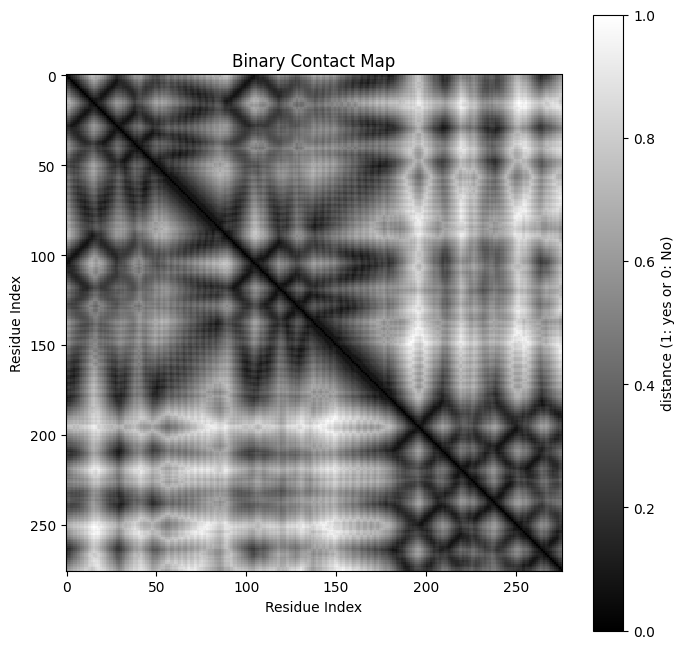

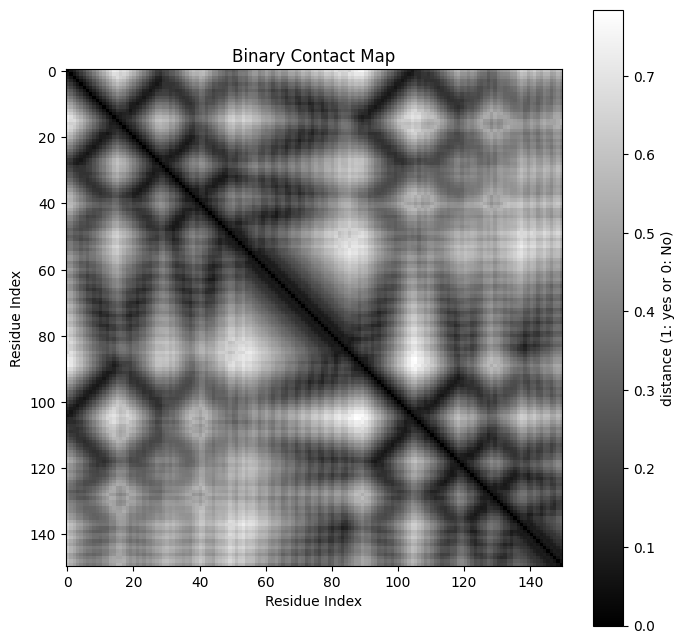

In [50]:
# Example usage:
# Let's say `contact_vec` is your vector with shape (37950,). Replace this with your actual data.
contact_vec = np.random.rand(37950)  # This is a placeholder

# Convert the vector to a contact map matrix
# contact_map = vector_to_contact_map(contact_maps[900].reshape(-1))
contact_map = map_list[0][:,:,0]
print(contact_map.shape)
# Visualize the contact map using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="distance (1: yes or 0: No)")
plt.show()

contact_map = map_list[0][:150,:150,0]
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="distance (1: yes or 0: No)")
plt.show()

(276, 276, 3)
torch.Size([1, 32, 3, 224, 224])


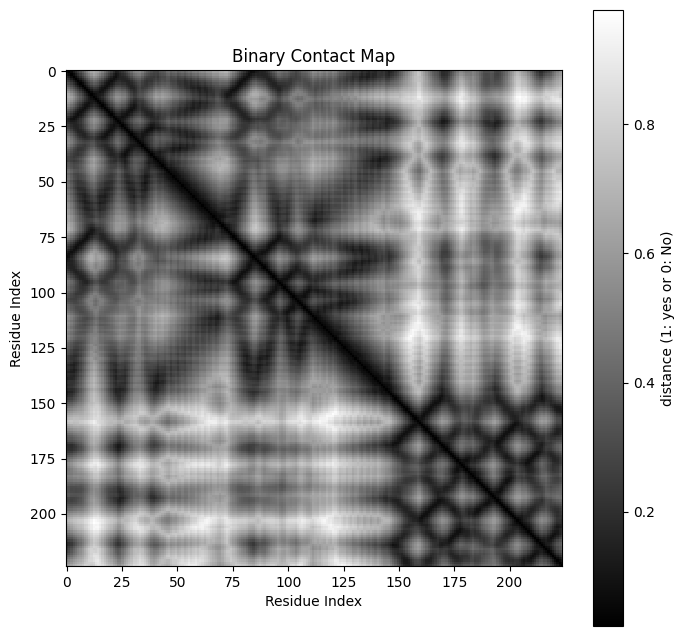

(150, 150, 3)
torch.Size([1, 32, 3, 224, 224])


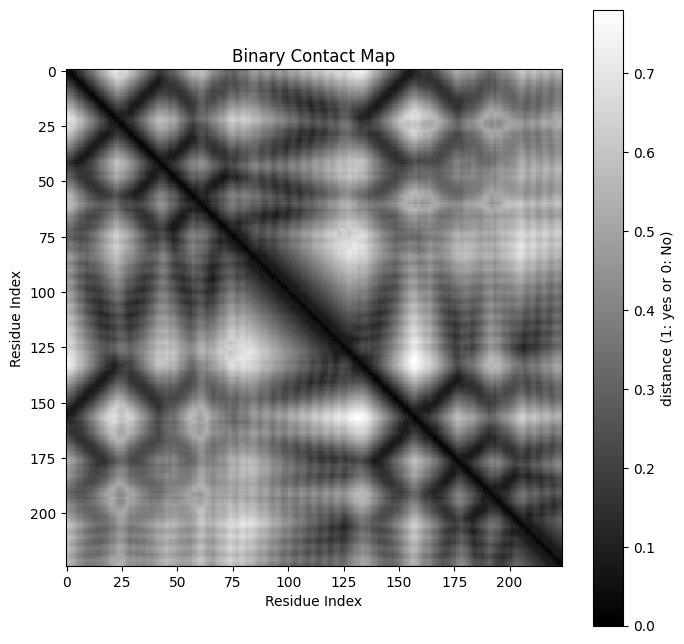

In [61]:

print(map_list[0].shape)
b = image_processor(map_list, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=True, size=224, do_center_crop=False)
print(b['pixel_values'].shape)
contact_map = b['pixel_values'][0, 0, 0, :, :]
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="distance (1: yes or 0: No)")
plt.show()


map_list_short = [i[:150, :150, :] for i in map_list]
print(map_list_short[0].shape)
b = image_processor(map_list_short, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=True, size=224, do_center_crop=False)
print(b['pixel_values'].shape)
contact_map = b['pixel_values'][0, 0, 0, :, :]
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="distance (1: yes or 0: No)")
plt.show()

In [45]:
a=map_list[0][:100,:100,:]
print(a.shape)
# b = image_processor(a, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=True, size=[224, 224])
# b = image_processor(a, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=False)
back=np.zeros((224,224,3))
back[:100,:100,:]=a
b = image_processor(back, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=False, do_center_crop=False)
# b = image_processor(back, return_tensors="pt", do_rescale=False, offset=False, do_normalize=False, do_resize=True, size=[224,224], do_center_crop=False)
c=b['pixel_values'][0,0,0]
print(c.shape)
d=a[:,:,0]
print(d.shape)
print(c)
print(d)

(100, 100, 3)
torch.Size([224, 224])
(100, 100)
tensor([[0.0000, 0.0614, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0614, 0.0000, 0.0601,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0601, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)
[[0.         0.06137533 0.09999483 ... 0.3588073  0.32841434 0.27128245]
 [0.06137533 0.         0.06005734 ... 0.30704371 0.27689615 0.22155744]
 [0.09999483 0.06005734 0.         ... 0.25943856 0.2296494  0.17345286]
 ...
 [0.3588073  0.30704371 0.25943856 ... 0.         0.06111426 0.10914952]
 [0.32841434 0.27689615 0.2296494  ... 0.06111426 0.         0.05978399]
 [0.27128245 0.22155744 0.17345286 ... 0.10914952 0.05978399 0.        ]]


In [172]:
b['pixel_values'].shape

torch.Size([1, 1, 3, 224, 224])

In [161]:
res['attentions'][0].shape

torch.Size([1, 12, 3137, 3137])

In [59]:
print(input_map['pixel_values'].shape)

torch.Size([1, 32, 3, 224, 224])


In [198]:
# input_map.keys()
a = torch.concatenate((input_map['pixel_values'], input_map['pixel_values']), dim=0)
# # print(map['pixel_values'].shape)
a.shape

outputs=model(a)
last_hidden_states = outputs.last_hidden_state
print(last_hidden_states.shape)
print(last_hidden_states[0,0:5,0:5])
print(last_hidden_states[1,0:5,0:5])

torch.Size([2, 3137, 768])
tensor([[ 1.0156, -0.8093, -0.5340,  0.5861, -0.1482],
        [ 0.5958, -0.7162, -1.4079,  0.9213, -0.0739],
        [ 0.6431, -0.3069, -1.3309,  0.8054, -0.0127],
        [ 0.8251, -0.5084, -1.0010,  0.5370,  0.7043],
        [ 0.9486, -0.1805, -0.8037,  0.9631,  0.5647]],
       grad_fn=<SliceBackward0>)
tensor([[ 1.0156, -0.8093, -0.5340,  0.5861, -0.1482],
        [ 0.5958, -0.7162, -1.4079,  0.9213, -0.0739],
        [ 0.6431, -0.3069, -1.3309,  0.8054, -0.0127],
        [ 0.8251, -0.5084, -1.0010,  0.5370,  0.7043],
        [ 0.9486, -0.1805, -0.8037,  0.9631,  0.5647]],
       grad_fn=<SliceBackward0>)


In [17]:
map_list[0].shape

(276, 276, 3)

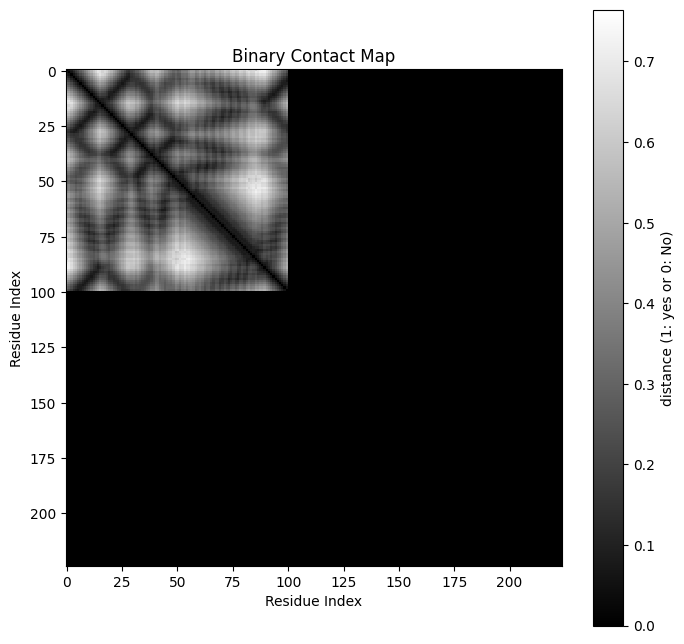

In [46]:


# Example usage:
# Let's say `contact_vec` is your vector with shape (37950,). Replace this with your actual data.
contact_vec = np.random.rand(37950)  # This is a placeholder

# Convert the vector to a contact map matrix
# contact_map = vector_to_contact_map(contact_maps[900].reshape(-1))
contact_map = map_list[0][:,:,0]

# Visualize the contact map using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(c, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="distance (1: yes or 0: No)")
plt.show()

In [ ]:
from Bio.PDB import PDBParser, PPBuilder

# Replace with your PDB file path
pdb_file = "./data/MD/dev_data/r1/1k5n_A.pdb"

# Create a PDB parser object
parser = PDBParser(QUIET=True)

# Parse the structure from the PDB file
structure = parser.get_structure("protein", pdb_file)

# Initialize the polypeptide builder
ppb = PPBuilder()

# Extract sequences from all chains in the structure
for model in structure:
    for chain in model:
        # Build polypeptides for the chain (could be more than one segment)
        polypeptides = ppb.build_peptides(chain)
        for poly_index, poly in enumerate(polypeptides):
            sequence = poly.get_sequence()
            print(f"Chain {chain.id} (segment {poly_index}): {sequence}")

In [ ]:
### test vivit model

In [ ]:
from transformers import VivitModel
import torch
# model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400", attn_implementation="sdpa", torch_dtype=torch.float16)
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400", attn_implementation="")

OSError: google/vivit-b-16x2-kinetics600 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [36]:
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400")
print(map_list[0].shape)
input_map = image_processor(map_list, return_tensors="pt", do_rescale=False, offset=False, )
result = model(**input_map)

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(276, 276, 3)


In [38]:
print(result.last_hidden_state.shape)

torch.Size([1, 3137, 768])


In [41]:
small_map_list=[map[0:100, 0:100, :] for map in map_list]
print(small_map_list[0].shape)
print(len(small_map_list))
small_input_map = image_processor(small_map_list, return_tensors="pt", do_rescale=False, offset=False, )
result = model(**small_input_map)

(100, 100, 3)
32


torch.Size([1, 32, 3, 224, 224])


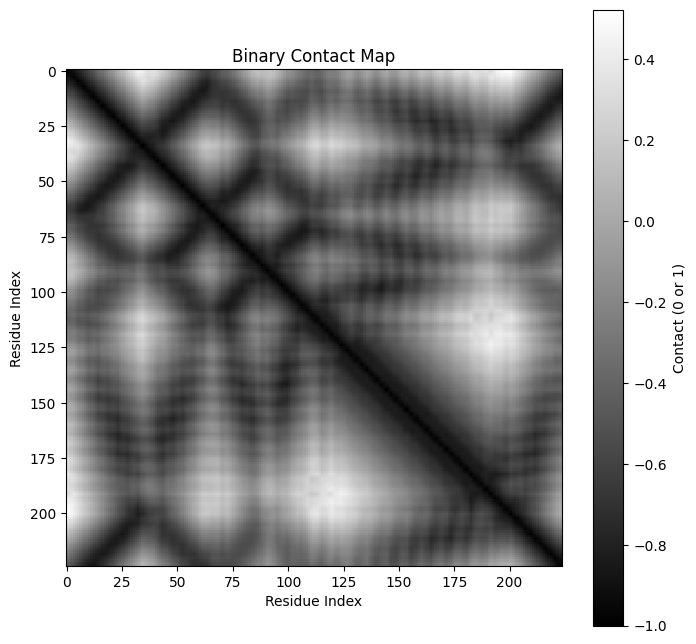

In [44]:
print(small_input_map['pixel_values'].shape)
processed_map = np.array(small_input_map['pixel_values'].squeeze(0).permute(0, 2, 3, 1))
# inputs_video = np.reshape(inputs['pixel_values'], (32, 224, 224, -1))
processed_map.shape

contact_map = processed_map[0][:,:,0]

# Visualize the contact map using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="Contact (0 or 1)")
plt.show()

In [ ]:
import torch
import os
import mdtraj as md
import numpy as np
import math
from Bio.PDB import PDBParser, PPBuilder
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from transformers import VivitImageProcessor

class ProteinMDDataset(Dataset):
    def __init__(self, samples, configs,mode="train"):
        self.original_samples = samples
    def __len__(self):
           return len(self.original_samples)
    def __getitem__(self, idx):
        pid, seq, traj = self.original_samples[idx]
        return pid, seq, traj


def custom_collate(batch):
    pid, seq, trajs = zip(*batch)
    # Remove the extra dimension from each contact sample
    traj_list = [traj.squeeze(0) for traj in trajs]
    # Now each traj has shape [32, 3, 224, 224]
    # Stack them along a new first dimension (batch dimension)
    traj_batch = torch.stack(traj_list, dim=0)
    batched_data = {'pid': pid, 'seq': seq, 'traj': traj_batch}
    # return pid, seq, contacts
    return batched_data

def prepare_dataloaders(configs):
    samples = prepare_samples(configs.train_settings.Atlas_data_path, 
                              configs.model.MD_encoder.model_name, 
                              configs.HF_cache_path)
    total_samples = len(samples)
    val_size = int(total_samples * 0.1)
    test_size = int(total_samples * 0.1)
    train_size = total_samples - val_size - test_size
    train_samples, val_samples, test_samples = random_split(samples, [train_size, val_size, test_size])

    samples_hard = prepare_samples(configs.train_settings.Atlas_test_path, 
                              configs.model.MD_encoder.model_name, 
                              configs.HF_cache_path)
    hard_num = len(samples_hard)
    val_size = int(hard_num * 0.5)
    test_size = hard_num - val_size
    val_hard, test_hard = random_split(samples_hard, [val_size, test_size])
    val_samples = val_samples + val_hard
    test_samples = test_samples + test_hard


    print(f"train samples: {len(train_samples)}, val samples: {len(val_samples)}, test samples: {len(test_samples)}")
    # Create DataLoader for each split
    train_dataset = ProteinMDDataset(train_samples, configs=configs, mode="train")
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=configs.train_settings.batch_size,
        shuffle=True,
        collate_fn=custom_collate,
        drop_last=False
    )

    val_dataset = ProteinMDDataset(val_samples, configs=configs, mode="val")
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=configs.train_settings.batch_size,
        shuffle=False,  # No need to shuffle validation data
        collate_fn=custom_collate,
        drop_last=False
    )

    test_dataset = ProteinMDDataset(test_samples, configs=configs, mode="val")
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=configs.train_settings.batch_size,
        shuffle=False,  # No need to shuffle validation data
        collate_fn=custom_collate,
        drop_last=False
    )

    # dataset = ProteinMDDataset(samples, configs=configs, mode = "train")
    # dataloader = DataLoader(dataset, batch_size=configs.train_settings.batch_size, shuffle=True, collate_fn=custom_collate,drop_last=False)
    return train_dataloader, val_dataloader, test_dataloader



def vector_to_contact_map(vec):
    """
    Converts a vector of pairwise contact values into a symmetric contact map matrix.
    
    Args:
        vec (np.ndarray): 1D array of length L, where L = N*(N-1)/2.
    
    Returns:
        contact_map (np.ndarray): 2D symmetric array of shape (N, N).
    """
    num_pairs = vec.shape[0]
    # Calculate N using the quadratic formula: N = (1 + sqrt(1+8L)) / 2
    N = int((1 + math.sqrt(1 + 8 * num_pairs)) / 2)
    
    # Initialize an empty contact map matrix
    contact_map = np.zeros((N, N))
    
    # Get indices for the upper triangle (excluding the diagonal)
    triu_indices = np.triu_indices(N, k=1)
    
    # Fill the upper triangle with the vector values
    contact_map[triu_indices] = vec
    
    # Mirror the upper triangle to the lower triangle to make it symmetric
    contact_map = contact_map + contact_map.T
    
    return contact_map

def pdb2seq(pdb_path):
    # Create a PDB parser object
    parser = PDBParser(QUIET=True)
    
    # Parse the structure from the PDB file
    structure = parser.get_structure("protein", pdb_path)
    
    # Initialize the polypeptide builder
    ppb = PPBuilder()
    
    # Extract sequences from all chains in the structure
    for model in structure:
        for chain in model:
            # Build polypeptides for the chain (could be more than one segment)
            polypeptides = ppb.build_peptides(chain)
            for poly_index, poly in enumerate(polypeptides):
                sequence = poly.get_sequence()
                # print(f"Chain {chain.id} (segment {poly_index}): {sequence}")
    return sequence

def normalize_contact_map(contact_map):
    # Option 1: Divide by maximum value (if maximum is known and consistent)
    max_val = contact_map.max()  # or a fixed value like 6.28 if appropriate
    normalized_map = contact_map / max_val
    # Optionally clip to [0,1] to ensure all values are within range
    normalized_map = np.clip(normalized_map, 0, 1)
    return normalized_map

def prepare_samples(data_folder2search, model_name, cache_path):
    image_processor = VivitImageProcessor.from_pretrained(model_name, cache_dir=cache_path)
    # Specify the parent folder (folder A)
    folder_A = data_folder2search
    samples = []
    
    # Iterate through each subfolder under folder_A
    data={}
    for subfolder in os.listdir(folder_A):
        subfolder_path = os.path.join(folder_A, subfolder)
        
        # Check if the path is a directory
        if os.path.isdir(subfolder_path):
            num_xtc=0
            num_pdb=0
            traj_files=[]

            for file_name in os.listdir(subfolder_path):
                if file_name.endswith(".xtc"):
                    file_xtc_path = os.path.join(subfolder_path, file_name)
                    traj_files.append(file_xtc_path)
                    # num_xtc += 1
                elif file_name.endswith(".pdb"):
                    file_pdb_path = os.path.join(subfolder_path, file_name)
                    pid = file_name.split(".")[0]
                    # num_pdb += 1
            sequence = pdb2seq(file_pdb_path)
            data[pid]={'ind2seq':{}, 'ind2map':{}}
            fragments, frag_contact = fragment_sequence(sequence, None, fixed_length=224, overlap=30)
            data_len=len(fragments)
            for i in range(data_len):
                data[pid]['ind2map'][i]=[]

            for file_xtc_path in traj_files:
                traj = md.load(file_xtc_path, top=file_pdb_path)
                # cutoff = 7  # in nanometers
                # contact_maps = []
                for frame in traj:
                    # compute pairwise distances
                    distances = md.compute_distances(frame, traj.topology.select_pairs('name CA', 'name CA')) # [1, L] 
                    # generate contact map: 1 if distance < cutoff, else 0
                    # contact_map = (distances < cutoff).astype(int)
                    contact_map = vector_to_contact_map(distances.reshape(-1)) # [N, N]

                    fragments, frag_contact = fragment_sequence(sequence, contact_map, fixed_length=224, overlap=30)
                    for i in range(len(fragments)):
                        frag_seq=fragments[i]
                        contact_map=frag_contact[i]
                        contact_map = np.expand_dims(contact_map, axis=-1) # [N, N, 1]
                        normalized_map = normalize_contact_map(contact_map) # [N, N, 1]
                        three_channel_map = np.repeat(normalized_map, 3, axis=-1) # [N, N, 3]
                        data[pid]['ind2seq'][i]=frag_seq
                        data[pid]['ind2map'][i].append(three_channel_map)
                        # contact_maps.append(three_channel_map)

                for i in range(len(fragments)):
                    pid_i = pid+"_"+str(i)
                    seq_i = data[pid]['ind2seq'][i]
                    traj = image_processor(data[pid]['ind2map'][i], return_tensors="pt", do_rescale=False, offset=False, 
                                           do_normalize=False, do_resize=True, size=[224, 224]) # [1, 1000, 3, 224, 224]
                    input_traj = traj['pixel_values']
                    groups = group_frames(input_traj)
                    for j in groups:
                        samples.append((pid_i, seq_i, groups[j]))
                
    return samples

def fragment_sequence(sequence, contact_map, fixed_length, overlap):
    fragments = []
    frag_contact = []
    stride = fixed_length - overlap
    start = 0
    seq_len = len(sequence)
    while start < seq_len:
        end = min(start + fixed_length, seq_len)
        fragment = sequence[start:end]
        fragments.append(fragment)  # Add fragment *before* checking length
        if contact_map.size!=0:
            if end-start<fixed_length:
                background = np.zeros((contact_map.shape[0],224, 224))
                background[:,:end-start, :end-start] = contact_map[:,start:end, start:end]
                frag_contact.append(background)
            else:
                frag_contact.append(contact_map[:, start:end, start:end])
        if end == seq_len: #check if the end of the sequence has been reached
            break
        start += stride
    return fragments, frag_contact


def group_frames(traj, group_size=32):
    """
    Group frames into sets of specified size.
    
    Args:
        total_frames (int): Total number of frames
        group_size (int): Number of frames in each group
        
    Returns:
        list: List of lists, where each inner list is a group of frames
    """
    total_frames = traj.shape[1]
    groups = []
    
    # Calculate how many complete groups we'll have
    num_complete_groups = total_frames // group_size
    
    # Group the frames
    for i in range(num_complete_groups):
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = traj[:,start_idx:end_idx,:,:,:]
        groups.append(group)
    
    # Handle any remaining frames
    remaining_frames = total_frames % group_size
    if remaining_frames > 0:
        group = traj[:,total_frames-32:,:,:,:]
        groups.append(group)
    
    processed_arrays = [arr.squeeze(0) for arr in groups]  # shape becomes [32, 3, 224, 224]
    # Stack along a new axis (axis=0)
    result = torch.stack(processed_arrays, axis=0) # [list_len, 32, 3, 224, 224]
    return result

import psutil
import os

def get_memory_usage_gb():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    memory_usage_gb = mem_info.rss / (1024 ** 3)  # 转换为 GB
    return memory_usage_gb

In [134]:
import subprocess
def get_gpu_usage_smi():
    result = subprocess.run(['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total', '--format=csv,noheader,nounits'], 
                            stdout=subprocess.PIPE, text=True)
    lines = result.stdout.strip().split('\n')
    usage_info = []
    for i, line in enumerate(lines):
        gpu_util, mem_used, mem_total = line.split(', ')
        usage_info.append({
            'gpu_index': i,
            'gpu_utilization_percent': int(gpu_util),
            'memory_used_MB': int(mem_used),
            'memory_total_MB': int(mem_total),
        })
    return usage_info

usage = get_gpu_usage_smi()
for gpu in usage:
        print(f"GPU {gpu['gpu_index']}:")
        print(f"  GPU Utilization: {gpu['gpu_utilization_percent']}%")
        print(f"  Memory Used: {gpu['memory_used_MB']} MB")
        print(f"  Memory Total: {gpu['memory_total_MB']} MB")

GPU 0:
  GPU Utilization: 10%
  Memory Used: 2057 MB
  Memory Total: 11264 MB


In [ ]:
def vectors_to_contact_maps(vecs):
    """
    Converts multiple vectors of pairwise contact values into symmetric contact map matrices.
    
    Args:
        vecs (np.ndarray): 2D array of shape (n, L),
                           where L = N*(N-1)/2 and n is number of vectors.
    
    Returns:
        contact_maps (np.ndarray): 3D array of shape (n, N, N).
    """
    n, num_pairs = vecs.shape
    # 计算N
    N = int((1 + math.sqrt(1 + 8 * num_pairs)) / 2)
    
    # 初始化输出数组
    contact_maps = np.zeros((n, N, N), dtype=vecs.dtype)
    
    # 获取上三角索引（不包括对角线）
    triu_indices = np.triu_indices(N, k=1)
    
    # 给所有矩阵的上三角赋值
    contact_maps[:, triu_indices[0], triu_indices[1]] = vecs
    
    # 镜像到下三角，使矩阵对称
    contact_maps = contact_maps + np.transpose(contact_maps, (0, 2, 1))
    
    return contact_maps

data_folder2search='/cluster/pixstor/xudong-lab/yuexu/D_PLM/Atlas_data/'
model_name='google/vivit-b-16x2-kinetics400'
list_num=0
output_folder='/cluster/pixstor/xudong-lab/yuexu/D_PLM/processed_Atlas_data'

import numpy as np
from transformers import VivitImageProcessor, VivitModel
import torch

image_processor = VivitImageProcessor.from_pretrained(model_name)
model = VivitModel.from_pretrained(model_name)
# Specify the parent folder (folder A)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VivitModel.from_pretrained(model_name).to(device)
folder_A = data_folder2search
samples = []

# Iterate through each subfolder under folder_A
#data={}
# for subfolder in os.listdir(folder_A):
subfolder = os.listdir(folder_A)[0]

subfolder = '2ysk_A'
subfolder = '4oj6_C'
subfolder_path = os.path.abspath(os.path.join(folder_A, subfolder))

# Check if the path is a directory
# if os.path.isdir(subfolder_path) and subfolder_path in sub_list:
traj_files=[]
for file_name in os.listdir(subfolder_path):
    if file_name.endswith(".xtc"):
        file_xtc_path = os.path.join(subfolder_path, file_name)
        traj_files.append(file_xtc_path)
        # num_xtc += 1
    elif file_name.endswith(".pdb"):
        file_pdb_path = os.path.join(subfolder_path, file_name)
        pid = file_name.split(".")[0]

    # num_pdb += 1
sequence = pdb2seq(file_pdb_path)
#fragments, frag_contact = fragment_sequence(sequence, np.array([]), fixed_length=224, overlap=30)
#data_len=len(fragments)
rep=0

file_xtc_path = traj_files[0]
#data[pid]={'ind2seq':{}, 'ind2map':{}}
#for i in range(data_len):
#     data[pid]['ind2map'][i]=[]
traj = md.load(file_xtc_path, top=file_pdb_path)
# cutoff = 7  # in nanometers
# contact_maps = []
distances = md.compute_distances(traj, traj.topology.select_pairs('name CA', 'name CA'))
contact_maps = vectors_to_contact_maps(distances) # [n, N, N]
fragments, frag_contacts = fragment_sequence(sequence, contact_maps, fixed_length=224, overlap=30)
# for i in range(len(fragments)):
i=0
frag_seq=fragments[i]
frag_contact=frag_contacts[i]
frag_contact = np.expand_dims(frag_contact, axis=-1) # [n, N, N, 1]
frag_contact = normalize_contact_map(frag_contact) # [n, N, N, 1]
frag_contact = np.repeat(frag_contact, 3, axis=-1) # [n, N, N, 3]
#data[pid]['ind2seq'][i]=frag_seq
#data[pid]['ind2map'][i]=frag_contact
#fo i in range(len(fragments)):
pid_i = pid+"#frag"+str(i)
h5id = pid_i+"#rep"+str(rep)
#seq_i = data[pid]['ind2seq'][i]
seq_i = frag_seq
# traj = image_processor(data[pid]['ind2map'][i], return_tensors="pt", do_rescale=False, offset=False, 
#                        do_normalize=False, do_resize=True, size=[224, 224]) # [1, 1000, 3, 224, 224]
images = image_processor(list(frag_contact), return_tensors="pt", do_rescale=False, offset=False, 
                       do_normalize=False, do_resize=False) # [1, 1000, 3, 224, 224]
images = images['pixel_values']
groups = group_frames(images)
groups = groups.to(device)
sub_num=groups.shape[0]//8
sub_remain=groups.shape[0]%8
rep_list=[]
print(get_memory_usage_gb())
for z in range(sub_num):
    print(z)
    sub_groups = groups[z*8:z*8+8]
    with torch.no_grad():
        vivit_output = model(sub_groups)
    last_hidden_states = vivit_output.last_hidden_state #[list_len, 3137, 768]
    cls_representation = last_hidden_states[:, 0, :] #[list_len, 1, 768]
    # sub_list.append(cls_representation)
    rep_list.append(cls_representation.detach().cpu())
    print(get_memory_usage_gb())

if sub_remain!=0:
    sub_groups = groups[-sub_remain:]
    with torch.no_grad():
        vivit_output = model(sub_groups)
    last_hidden_states = vivit_output.last_hidden_state #[list_len, 3137, 768]
    cls_representation = last_hidden_states[:, 0, :] #[list_len, 1, 768]
    rep_list.append(cls_representation.detach().cpu())

cls_representation = torch.cat(rep_list, dim=0) #[list_len, 1, 768]
pooled = cls_representation.mean(axis=0)  # shape: (768,)
del rep_list, images, groups, frag_contact
# samples.append((h5id, pid_i, seq_i, pooled))
saveh5((pid_i, seq_i, pooled), os.path.join(output_folder, h5id+".h5"))

In [ ]:
process_files=[]
process_folder='/cluster/pixstor/xudong-lab/yuexu/D_PLM/processed_Atlas_test/'
for file_name in os.listdir(process_folder):
    if file_name.split('#')[0] in process_files:
        continue
    else:
        process_files.append(file_name.split('#')[0])

data_files=[]
data_folder='/cluster/pixstor/xudong-lab/yuexu/D_PLM/Atlas_test/'
for file_name in os.listdir(data_folder):
    data_files.append(file_name)

print(len(process_files), len(data_files))


In [ ]:
# labels = torch.cat([torch.arange(batch_size, device=accelerator.device) for i in range(n_views)], dim=0)
# labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(accelerator.device)



In [35]:
labels = torch.cat([torch.arange(3) for i in range(2)], dim=0)
labels = torch.tensor([0,1,0,2,0,1,0,2])
labels

tensor([0, 1, 0, 2, 0, 1, 0, 2])

In [ ]:
import torch
# labels = torch.cat([torch.arange(4) for i in range(2)], dim=0)
labels = torch.tensor([0,1,0,2,0,1,0,2])
labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

labels


tensor([[1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.]])

In [38]:
import torch.nn.functional as F
features_struct=torch.rand(4,7)
features_seq=torch.rand(4,7)
features_struct = F.normalize(features_struct, dim=1)
features_seq = F.normalize(features_seq, dim=1)
features = torch.cat([features_struct, features_seq], dim=0)
similarity_matrix = torch.matmul(features, features.T)
similarity_matrix

tensor([[1.0000, 0.4727, 0.8975, 0.7695, 0.7408, 0.7446, 0.6329, 0.6612],
        [0.4727, 1.0000, 0.6748, 0.7332, 0.8421, 0.7428, 0.8604, 0.8967],
        [0.8975, 0.6748, 1.0000, 0.8639, 0.7770, 0.8605, 0.6755, 0.8038],
        [0.7695, 0.7332, 0.8639, 1.0000, 0.9102, 0.7454, 0.7854, 0.7651],
        [0.7408, 0.8421, 0.7770, 0.9102, 1.0000, 0.7026, 0.8573, 0.8185],
        [0.7446, 0.7428, 0.8605, 0.7454, 0.7026, 1.0000, 0.7178, 0.9403],
        [0.6329, 0.8604, 0.6755, 0.7854, 0.8573, 0.7178, 1.0000, 0.7757],
        [0.6612, 0.8967, 0.8038, 0.7651, 0.8185, 0.9403, 0.7757, 1.0000]])

In [27]:
mask = torch.eye(labels.shape[0], dtype=torch.bool)
print(mask)
labels = labels[~mask].view(labels.shape[0], -1)
print(labels)
similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
similarity_matrix

tensor([[ True, False, False, False, False, False],
        [False,  True, False, False, False, False],
        [False, False,  True, False, False, False],
        [False, False, False,  True, False, False],
        [False, False, False, False,  True, False],
        [False, False, False, False, False,  True]])
tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])


tensor([[0.5466, 0.5666, 0.9298, 0.7817, 0.4387],
        [0.5466, 0.7536, 0.5639, 0.7429, 0.9340],
        [0.5666, 0.7536, 0.5439, 0.9277, 0.7414],
        [0.9298, 0.5639, 0.5439, 0.6863, 0.3900],
        [0.7817, 0.7429, 0.9277, 0.6863, 0.7283],
        [0.4387, 0.9340, 0.7414, 0.3900, 0.7283]])

In [28]:
positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)


In [30]:
negatives

tensor([[0.5466, 0.5666, 0.7817, 0.4387],
        [0.5466, 0.7536, 0.5639, 0.9340],
        [0.5666, 0.7536, 0.5439, 0.9277],
        [0.5639, 0.5439, 0.6863, 0.3900],
        [0.7817, 0.9277, 0.6863, 0.7283],
        [0.4387, 0.9340, 0.3900, 0.7283]])

In [32]:
logits = torch.cat([positives, negatives], dim=1)
labels = torch.zeros(logits.shape[0], dtype=torch.long)


In [33]:
logits

tensor([[0.9298, 0.5466, 0.5666, 0.7817, 0.4387],
        [0.7429, 0.5466, 0.7536, 0.5639, 0.9340],
        [0.7414, 0.5666, 0.7536, 0.5439, 0.9277],
        [0.9298, 0.5639, 0.5439, 0.6863, 0.3900],
        [0.7429, 0.7817, 0.9277, 0.6863, 0.7283],
        [0.7414, 0.4387, 0.9340, 0.3900, 0.7283]])

In [34]:
labels

tensor([0, 0, 0, 0, 0, 0])

In [40]:
import esm_adapterH
from box import Box
config = {'enable': True, 'num_end_adapter_layers': 12, 'module_type': "MLP1"}
config = Box(config)
config.enable
esm2, alphabet = esm_adapterH.pretrained.esm2_t30_150M_UR50D(config)
batch_converter = alphabet.get_batch_converter(truncation_seq_length=200)
seq1='MDKVLNREESMELMDLLGLDRSAWGNIPVMRKAYLKKCKELHPDKGGDEDKMKRMNFLYKKMEQGVKVAHQPDFGTWNSSEVGCDFPPNSDTLYCKEWPNCATNPSVHCPCLMCMLKLRHRNRKFLRSSPLVWIDCYCFDCFRQWFGCDLTQEALHCWEKVLGDTPYRDLKL'
seq2='MSKNKDQRTAKTLERTWDTLNHLLFISSCLYKLNLKSVAQITLSILAMIISTSLIIAAIIFIASANHKVTPT\
    TAIIQDATSQIKNTTPTYLTQNPQLGISPSNPSEITSQITTILASTTPGVKSTLQSTTVKTKNTTTTQTQPSKPT\
        TKQRQNKPPSKPNNDFHFEVFNFVPCSICSNNPTCWAICKRIPNKKPGKKTTTKPTKKPTLKTTKKDPKPQTTKSKEVPTTKPTEEPTINTTK\
            TNIITTLLTSNTTGNPELTSQMETFHSTSSEGNPSPSQVSTTSEYPSQPSSPPNTPRQ'


In [94]:
alphabet.all_toks

['<cls>',
 '<pad>',
 '<eos>',
 '<unk>',
 'L',
 'A',
 'G',
 'V',
 'S',
 'E',
 'R',
 'T',
 'I',
 'D',
 'P',
 'K',
 'Q',
 'N',
 'F',
 'Y',
 'M',
 'H',
 'W',
 'C',
 'X',
 'B',
 'U',
 'Z',
 'O',
 '.',
 '-',
 '<null_1>',
 '<mask>']

In [118]:
# batch_labels, batch_strs, batch_tokens = batch_converter([('seq1',seq1), ('seq2',seq2)])
batch_labels, batch_strs, batch_tokens = batch_converter([('seq1',seq1)])
outputs = esm2(batch_tokens, repr_layers=[esm2.num_layers], return_contacts=False)


In [119]:
outputs.keys()
mask = ((batch_tokens != alphabet.padding_idx) & (batch_tokens != alphabet.cls_idx) & (
                    batch_tokens != alphabet.eos_idx))
residue_feature_embedding = outputs['representations'][esm2.num_layers][mask]

In [124]:
residue_feature_embedding.shape

torch.Size([172, 640])

In [123]:
print(mask.shape)
mask

torch.Size([1, 174])


tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  

In [111]:
outputs['representations'][esm2.num_layers].shape

torch.Size([2, 202, 640])

In [89]:
outputs['logits'][0,:5,:]

tensor([[ 19.3523,  -5.0466,   4.7599,  -4.9001,  -1.6688,  -0.9734,   0.1751,
          -0.9683,   0.2612,  -0.1574,   1.3448,  -1.7355,  -0.2613,  -0.3624,
          -1.3045,   1.0823,  -0.9245,   0.3088,  -2.7846,  -1.6144,   2.6701,
          -2.2198,  -2.5766,  -2.1414,  -6.8320,  -8.9827, -12.3936, -10.7671,
         -16.3860, -15.9422, -15.4255, -17.0992,  -4.9094],
        [ -5.8481, -10.2043,  -7.6505, -10.1891,   0.1361,  -1.2317,  -0.7126,
          -0.3726,  -0.9468,  -0.5091,  -0.5760,  -1.5764,  -0.0470,  -0.5554,
          -1.2230,   0.1814,  -1.3063,  -0.8021,  -1.1079,  -1.2042,  10.5108,
          -2.0586,  -1.2919,  -2.0041,  -2.9631,  -9.6436, -10.1475, -10.5877,
         -16.1790, -15.7093, -15.0280, -16.3700, -10.2238],
        [-10.8190, -15.6347, -10.4180, -15.6570,  -0.5078,   0.0263,   0.0419,
          -0.4917,   0.2347,   0.5237,  -0.1507,  -0.3582,  -0.7710,   3.5694,
          -1.1319,   0.6411,  -1.0973,  -0.2083,  -1.3865,  -1.0799,  -0.8308,
          -

In [100]:
# np.log(outputs['logits'][0,0,1].detach().numpy()/outputs['logits'][0,0,2].detach().numpy())
# outputs['logits'][0,0,1].detach().numpy()/outputs['logits'][0,0,2].detach().numpy()
log_soft = torch.nn.functional.softmax(outputs['logits'], dim=2)
log_soft[0,:5,:]

tensor([[1.0000e+00, 2.5334e-11, 4.5987e-07, 2.9333e-11, 7.4243e-10, 1.4882e-09,
         4.6930e-09, 1.4959e-09, 5.1152e-09, 3.3656e-09, 1.5117e-08, 6.9454e-10,
         3.0333e-09, 2.7417e-09, 1.0688e-09, 1.1627e-08, 1.5629e-09, 5.3646e-09,
         2.4326e-10, 7.8392e-10, 5.6889e-08, 4.2794e-10, 2.9951e-10, 4.6284e-10,
         4.2492e-12, 4.9463e-13, 1.6328e-14, 8.3046e-14, 3.0134e-16, 4.6970e-16,
         7.8745e-16, 1.4768e-16, 2.9061e-11],
        [7.8579e-08, 1.0079e-09, 1.2958e-08, 1.0233e-09, 3.1204e-05, 7.9463e-06,
         1.3354e-05, 1.8762e-05, 1.0566e-05, 1.6369e-05, 1.5308e-05, 5.6295e-06,
         2.5982e-05, 1.5628e-05, 8.0161e-06, 3.2650e-05, 7.3753e-06, 1.2211e-05,
         8.9939e-06, 8.1681e-06, 9.9975e-01, 3.4760e-06, 7.4824e-06, 3.6704e-06,
         1.4069e-06, 1.7659e-09, 1.0668e-09, 6.8698e-10, 2.5625e-12, 4.0988e-12,
         8.1008e-12, 2.1170e-12, 9.8852e-10],
        [4.1068e-07, 3.3270e-09, 6.1326e-07, 3.2536e-09, 1.2348e-02, 2.1065e-02,
         2.1396e-

In [43]:
import mdtraj as md
import numpy as np
traj = md.load("./NRI_paper/MD_trajectory/MD trajectory/Pin1-for-energy-calculation/E12A.pdb")

In [83]:
traj

<mdtraj.Trajectory with 5000 frames, 73 atoms, 73 residues, and unitcells at 0x2275b91fdf0>

In [87]:
three_to_one = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H',
    'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q',
    'ARG': 'R', 'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}
sequence = ""
for residue in traj.topology.residues:
        sequence += three_to_one.get(residue.name, 'X')  # Get residue name (e.g., ALA, GLY, LYS)

print(sequence)
len(sequence)

KPGARSSGVYNINSWRSNRRSLVHQRPSREIRKELLNYQISEDELSFDSAAGLASGMKFDSARGMGVTSIILT


73

In [ ]:
n_residues = traj.topology.n_residues
rmsf = np.zeros(n_residues)
avg_positions = np.mean(traj.xyz, axis=0)  # Shape: (n_frames, n_atoms, 3)

In [64]:
traj.xyz.shape

(5000, 73, 3)

In [73]:
residue = next(traj.topology.residues)
i=0
atoms = residue.atoms
atom_indices = [atom.index for atom in atoms]
atom_indices
atom_positions = traj.xyz[:, i, :]  # Shape: (n_frames, n_atoms, 3)
print(atom_positions.shape)
print(avg_positions[i, :].shape)
deviations = atom_positions - avg_positions[i, :]
print(deviations.shape)

(5000, 3)
(3,)
(5000, 3)


In [75]:
np.sqrt(np.mean(np.sum(deviations ** 2, axis=1)))

0.27866495

In [185]:
import mdtraj as md
import numpy as np

three_to_one = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H',
    'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q',
    'ARG': 'R', 'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}


sequence

def calculate_rmsf_from_pdb(pdb_file):
    """
    Calculate RMSF for each residue in a PDB file with multiple models (conformations).
    
    Args:
        pdb_file (str): Path to the PDB file containing multiple models (frames).
    
    Returns:
        rmsf (np.ndarray): RMSF values for each residue.
    """
    # Load the PDB file with multiple models (frames)
    traj = md.load(pdb_file)

    # sequence = ""
    # for residue in traj.topology.residues:
    #         sequence += three_to_one.get(residue.name, 'X')  # Get residue name (e.g., ALA, GLY, LYS)

    # Calculate the number of residues and atoms
    n_residues = traj.topology.n_residues

    # Initialize a list to store RMSF for each residue
    rmsf = np.zeros(n_residues)

    # Calculate the average positions of each residue (CA atom positions)
    avg_positions = np.mean(traj.xyz, axis=0)  # Shape: (n_atoms, 3)

    # Loop through each residue and calculate RMSF
    for i, residue in enumerate(traj.topology.residues):
        # Select all atoms of the residue (typically just the CA atom)
        atoms = residue.atoms
        atom_indices = [atom.index for atom in atoms]

        # Extract the positions for these atoms over all frames
        atom_positions = traj.xyz[:, i, :]  # Shape: (n_frames, n_atoms, 3)

        # Calculate the deviation from the average position
        deviations = atom_positions - avg_positions[i, :]

        # Compute RMSF for the residue (mean squared deviations)
        rmsf[i] = np.sqrt(np.mean(np.sum(deviations ** 2, axis=1)))

    return np.mean(rmsf)

# Example usage
# pdb_file = "./NRI_paper/MD_trajectory/MD trajectory/Pin1-for-energy-calculation/E12A.pdb"  # PDB file with multiple models (frames)

# rmsf_values = calculate_rmsf_from_pdb(pdb_file)
# print(rmsf_values)


In [186]:
import os
import esm_adapterH
from box import Box
import esm

# config = {'enable': True, 'num_end_adapter_layers': 12, 'module_type': "MLP1"}
# config = Box(config)
# config.enable
# esm2, alphabet = esm_adapterH.pretrained.esm2_t30_150M_UR50D(config)

esm2, alphabet = esm.pretrained.esm2_t30_150M_UR50D()
batch_converter = alphabet.get_batch_converter()




# seq1='MDKVLNREESMELMDLLGLDRSAWGNIPVMRKAYLKKCKELHPDKGGDEDKMKRMNFLYKKMEQGVKVAHQPDFGTW
file2ddg={'L7A': 0.158, 'P9A': -1.376, 'E12A': -1.541, 'K13A': 0.066, 'R14A': -0.975, 'M15A': -1.123, 'S16A': -1.56, 'R17A':-1.598,
          'S18A': -0.920, 'R21A': -1.541, 'V22A': -1.309, 'Y23A': 0.485, 'F25A': 0.571, 'H27A': -1.443, 'I28A': -1.206,
          'T29A': -0.32, 'S32A': -1.302, 'W34A': -1.161, 'E35A': -0.836}

seq = 'MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEKITRTKEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE'

folder_path = './NRI_paper/MD_trajectory/MD trajectory/Pin1-for-energy-calculation/'
ddg_list=[]
emb_rmsf_list=[]
emb_esm2_list=[]
for file in os.listdir(folder_path):
    basename = file[:-4]
    file_path = os.path.join(folder_path, file)
    if basename in file2ddg.keys():
        ddg = file2ddg[basename]
    else:
        continue
    
    rmsf= calculate_rmsf_from_pdb(file_path)

    mut_ind = int(basename[1:-1])
    mut_AA = basename[-1]
    seq_mut = seq[:mut_ind-1] + mut_AA + seq[mut_ind-1+1:]

    batch_labels, batch_strs, batch_tokens = batch_converter([(basename, seq_mut)])
    outputs = esm2(batch_tokens, repr_layers=[esm2.num_layers], return_contacts=False)
    # mask = ((batch_tokens != alphabet.padding_idx) & (batch_tokens != alphabet.cls_idx) & (
    #                 batch_tokens != alphabet.eos_idx))
    # residue_feature_embedding = outputs['representations'][esm2.num_layers][mask]
    cls_embedding = outputs['representations'][esm2.num_layers][0][0]

    emb_rmsf = np.concatenate((cls_embedding.detach().numpy(), rmsf.reshape(-1)))
    emb_esm2 = cls_embedding.detach().numpy()

    ddg_list.append(ddg)
    emb_rmsf_list.append(emb_rmsf)
    emb_esm2_list.append(emb_esm2)

    # print(basename)
    # print(file_path)

In [190]:
emb_rmsf_list[0].reshape(1,-1).shape

(1, 641)

In [191]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
# import seaborn as sns
from scipy.stats import pearsonr

print(len(ddg_list),len(emb_rmsf_list),len(emb_esm2_list))
result_rmsf=[]
result_esm2=[]
ddg = []
for i in range(1,len(ddg_list)):
    cosine_simi_rmsf = cosine_similarity(emb_rmsf_list[i].reshape(1,-1), emb_rmsf_list[0].reshape(1,-1))
    cosine_simi_esm2 = cosine_similarity(emb_esm2_list[i].reshape(1,-1), emb_esm2_list[0].reshape(1,-1))
    score = ddg_list[i]-ddg_list[0]
    result_rmsf.append(cosine_simi_rmsf)
    result_esm2.append(cosine_simi_esm2)
    ddg.append(score)

19 19 19


In [199]:
emb_rmsf_list[i][-1]

0.13991823195390504

In [232]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
# import seaborn as sns
from scipy.stats import pearsonr

print(len(ddg_list),len(emb_rmsf_list),len(emb_esm2_list))
result_rmsf=[]
result_esm2=[]
ddg = []
for i in range(1,len(ddg_list)):
    cosine_simi_rmsf = cosine_similarity(emb_rmsf_list[i].reshape(1,-1), emb_rmsf_list[0].reshape(1,-1)).item()
    # cosine_simi_rmsf = emb_rmsf_list[i][-1]-emb_rmsf_list[0][-1]
    cosine_simi_esm2 = cosine_similarity(emb_esm2_list[i].reshape(1,-1), emb_esm2_list[0].reshape(1,-1)).item()
    score = ddg_list[i]-ddg_list[0]
    result_rmsf.append(cosine_simi_rmsf)
    result_esm2.append(cosine_simi_esm2)
    ddg.append(score)



19 19 19


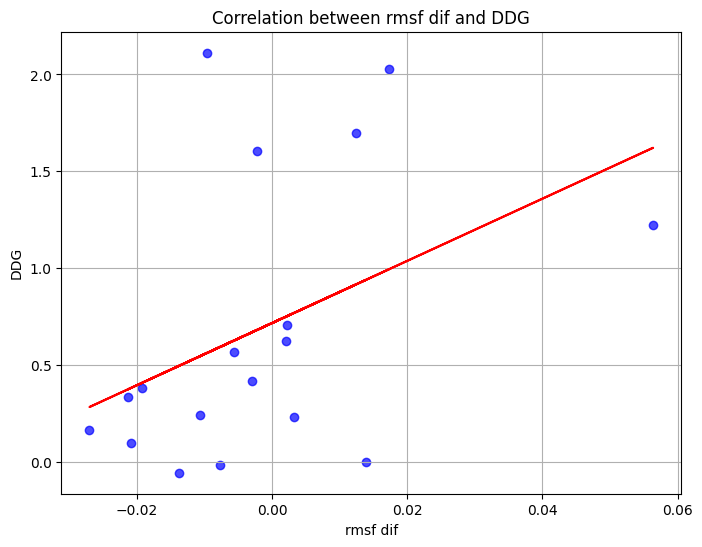

In [212]:
slope, intercept = np.polyfit(result_rmsf, ddg, 1)

# Create the fitted line using the slope and intercept
fit_line = slope * np.array(result_rmsf) + intercept

# Plot the fitted line
# plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')

plt.figure(figsize=(8, 6))
plt.scatter(result_rmsf, ddg, label="Cosine Similarity vs Scores", color='blue', alpha=0.7)
plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel('rmsf dif')
plt.ylabel('DDG')
plt.title('Correlation between rmsf dif and DDG')
plt.grid(True)
plt.show()

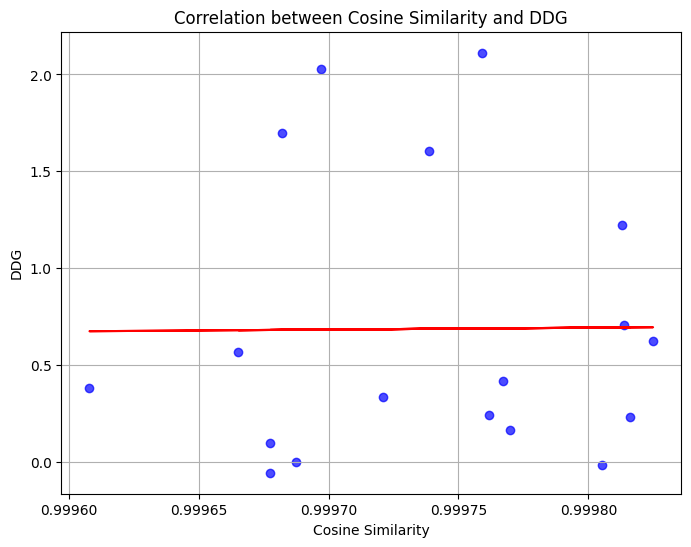

In [234]:
slope, intercept = np.polyfit(result_esm2, ddg, 1)

# Create the fitted line using the slope and intercept
fit_line = slope * np.array(result_esm2) + intercept

plt.figure(figsize=(8, 6))
plt.plot(result_esm2, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')

plt.scatter(result_esm2, ddg, label="Cosine Similarity vs Scores", color='blue', alpha=0.7)
plt.xlabel('Cosine Similarity')
plt.ylabel('DDG')
plt.title('Correlation between Cosine Similarity and DDG')
plt.grid(True)
plt.show()

In [230]:
result_rmsf[0].item()

0.9998136986298869

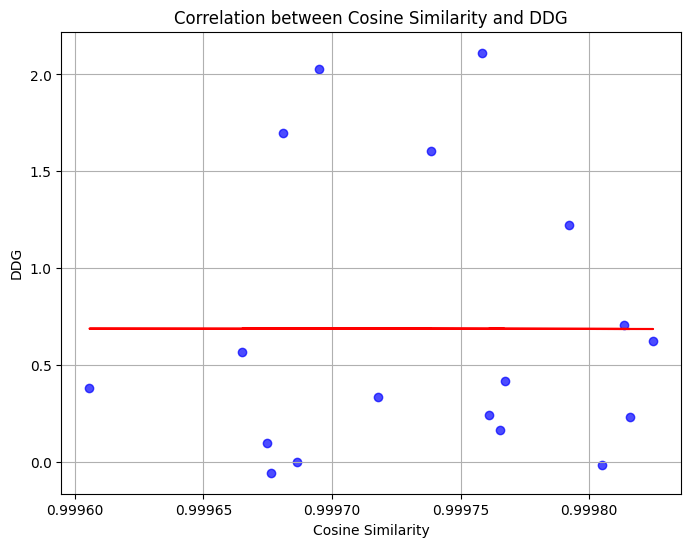

In [235]:
slope, intercept = np.polyfit(result_rmsf, ddg, 1)

# Create the fitted line using the slope and intercept
fit_line = slope * np.array(result_rmsf) + intercept

plt.figure(figsize=(8, 6))
plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')

plt.scatter(result_rmsf, ddg, label="Cosine Similarity vs Scores", color='blue', alpha=0.7)
plt.xlabel('Cosine Similarity')
plt.ylabel('DDG')
plt.title('Correlation between Cosine Similarity and DDG')
plt.grid(True)
plt.show()

In [164]:
cls_embedding = outputs['representations'][esm2.num_layers][0][0]




In [174]:
np.concatenate((cls_embedding.detach().numpy(), np.mean(rmsf).reshape(-1)))

array([-7.19246641e-02,  9.71741825e-02, -3.75479460e-03,  9.34580863e-02,
       -3.29132229e-01,  1.70724168e-02, -3.87391746e-02,  1.77973602e-02,
       -1.67449996e-01,  2.14350030e-01, -1.22891240e-01, -1.59355830e-02,
        2.02257499e-01, -6.46229237e-02,  8.61120299e-02,  1.14054814e-01,
        7.88616948e-03,  2.11822942e-01, -3.45274955e-02, -6.27737194e-02,
        4.35790308e-02,  1.03383258e-01,  7.93840885e-02, -4.86047529e-02,
       -1.14475593e-01, -1.15044050e-01,  1.54253483e-01, -3.20821963e-02,
       -1.23469800e-01, -4.72468704e-01, -8.77034292e-02,  2.01518849e-01,
       -9.66207497e-03, -1.09536022e-01, -1.67476758e-01,  2.66932230e-02,
       -2.34791085e-01, -4.88679409e-02,  2.74616592e-02,  6.87071234e-02,
       -1.00635894e-01,  2.02421650e-01, -1.45571977e-02, -2.70459414e-01,
       -1.73112750e-01, -1.01115353e-01, -5.29978387e-02, -1.09264858e-01,
       -1.03434384e-01,  1.45304710e-01,  1.36497309e-02, -1.02263995e-01,
       -1.11902570e-02, -

In [170]:
np.mean(rmsf)

0.12268148204439307

In [ ]:
import yaml
from utils.utils import load_configs, load_checkpoints_md, get_logging
from accelerate import Accelerator, DistributedDataParallelKwargs
from model import prepare_models
from inspect import signature
import esm

config_path = "./configs/representation_config.yaml"
result_path = ''
with open(config_path) as file:
    dict_config = yaml.full_load(file)

configs = load_configs(dict_config)

accelerator = Accelerator()

logging = get_logging(result_path)
simclr = prepare_models(logging, configs, accelerator)
simclr = load_checkpoints_md(simclr, configs, 
                             resume_path='/cluster/pixstor/xudong-lab/yuexu/D_PLM/results/test2/checkpoints/checkpoint_0030000.pth')
    
alphabet = simclr.model_seq.alphabet
batch_converter = alphabet.get_batch_converter(truncation_seq_length=configs.model.esm_encoder.max_length)

scores_vivit, file2ddg = evaluate_with_nri(
    accelerator=accelerator,
    model=simclr,
    batch_converter=batch_converter,
    alphabet=alphabet   
)

esm2, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
scores_esm2, file2ddg = evaluate_esm2_nri(
    accelerator=accelerator,
    model=esm2,
    batch_converter=batch_converter,
    alphabet=alphabet  

)

list_vivit=[]
list_esm2=[]
ddt=[]
for key in file2ddg.keys():
    list_vivit.append(scores_vivit[key])
    list_esm2.append(scores_esm2[key])
    ddt.append(file2ddg[key]-(-1.565))


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
# plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.scatter(list_vivit, ddt, label="dplm mut effct vs ddg", color='blue', alpha=0.7)
plt.xlabel('dplm mut effct')
plt.ylabel('DDG')
plt.title('Correlation between dplm mut effct and DDG')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
# plt.plot(result_rmsf, fit_line, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.scatter(list_esm2, ddt, label="esm2 mut effct vs ddg", color='blue', alpha=0.7)
plt.xlabel('esm2 mut effct')
plt.ylabel('DDG')
plt.title('Correlation between esm2 mut effct and DDG')
plt.grid(True)
plt.s

correlation_dplm = np.corrcoef(list_vivit, ddt)[0, 1]
correlation_esm2 = np.corrcoef(list_esm2, ddt)[0, 1]
print(f'correlation dplm: {correlation_dplm}\ncorrelation esm2: {correlation_esm2}')

In [ ]:
def evaluate_with_nri(accelerator, model, batch_converter, alphabet):
    file2ddg={'L7A': 0.158, 'P9A': -1.376, 'E12A': -1.541, 'K13A': 0.066, 'R14A': -0.975, 'M15A': -1.123, 'S16A': -1.56, 'R17A':-1.598,
          'S18A': -0.920, 'R21A': -1.541, 'V22A': -1.309, 'Y23A': 0.485, 'F25A': 0.571, 'H27A': -1.443, 'I28A': -1.206,
          'T29A': -0.32, 'S32A': -1.302, 'W34A': -1.161, 'E35A': -0.836}
    
    seq = 'MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEKITRTKEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE'
    batch_seq = [("pin1", seq)]
    with torch.inference_mode():
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_seq)
            # batch_tokens = batch_tokens.to(accelerator.device)
            model_signature = signature(model.forward)
            if 'batch_tokens' in model_signature.parameters:
                logits  = model(batch_tokens=batch_tokens, mode='sequence', return_embedding=True, return_logits=True)
            else:
                logits  = model(batch_tokens, mode='sequence', return_embedding=True, return_logits=True)
            
            log_soft = torch.nn.functional.softmax(logits, dim=2)
            log_soft = log_soft.detach().numpy()
    
    result = {}
    for key in file2ddg.keys():
        mut_ind = int(key[1:-1])
        mut_AA = key[-1]
        wt_AA = key[0]
        # seq_mut = seq[:mut_ind-1] + mut_AA + seq[mut_ind-1+1:]
        result[key] = np.log(log_soft[0,mut_ind-1,alphabet.all_toks.index(mut_AA)]/
                             log_soft[0,mut_ind-1,alphabet.all_toks.index(wt_AA)])
    
    return result, file2ddg


def evaluate_esm2_nri(accelerator, model, batch_converter, alphabet):
    file2ddg={'L7A': 0.158, 'P9A': -1.376, 'E12A': -1.541, 'K13A': 0.066, 'R14A': -0.975, 'M15A': -1.123, 'S16A': -1.56, 'R17A':-1.598,
          'S18A': -0.920, 'R21A': -1.541, 'V22A': -1.309, 'Y23A': 0.485, 'F25A': 0.571, 'H27A': -1.443, 'I28A': -1.206,
          'T29A': -0.32, 'S32A': -1.302, 'W34A': -1.161, 'E35A': -0.836}
    
    seq = 'MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEKITRTKEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE'
    batch_seq = [("pin1", seq)]
    with torch.inference_mode():
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_seq)
            # batch_tokens = batch_tokens.to(accelerator.device)
            outputs = model(batch_tokens, repr_layers=[esm2.num_layers], return_contacts=False)
            
            log_soft = torch.nn.functional.softmax(outputs['logits'], dim=2)
            log_soft = log_soft.detach().numpy()
    
    result = {}
    for key in file2ddg.keys():
        mut_ind = int(key[1:-1])
        mut_AA = key[-1]
        wt_AA = key[0]
        # seq_mut = seq[:mut_ind-1] + mut_AA + seq[mut_ind-1+1:]
        result[key] = np.log(log_soft[0,mut_ind-1,alphabet.all_toks.index(mut_AA)]/
                             log_soft[0,mut_ind-1,alphabet.all_toks.index(wt_AA)])
    
    return result, file2ddg


In [ ]:
import MDAnalysis as mda
import numpy as np
from sklearn.metrics import mutual_info_score
from scipy.spatial.distance import pdist, squareform

u = mda.Universe("./Atlas_test/1chd_A/1chd_A.pdb", "./Atlas_test/1chd_A/1chd_A_prod_R1_fit.xtc")  # replace with your files
protein = u.select_atoms("protein and name CA")     # using Cα atoms for residue-level analysis

n_residues = len(protein)
n_frames = len(u.trajectory)

# --------- STEP 2: Collect Displacement Vectors ---------
positions = np.zeros((n_frames, n_residues, 3))

for i, ts in enumerate(u.trajectory):
    positions[i] = protein.positions

mean_pos = np.mean(positions, axis=0)
displacements = positions - mean_pos[None, :, :]  # shape: (frames, residues, 3)

# --------- STEP 3: Compute DCCM ---------
dccm = np.zeros((n_residues, n_residues))
for i in range(n_residues):
    for j in range(n_residues):
        vi = displacements[:, i, :].reshape(n_frames, 3)
        vj = displacements[:, j, :].reshape(n_frames, 3)
        num = np.sum(np.sum(vi * vj, axis=1))  # dot product over time
        denom = np.sqrt(np.sum(np.sum(vi**2, axis=1)) * np.sum(np.sum(vj**2, axis=1)))
        dccm[i, j] = num / denom if denom > 0 else 0.0

# --------- STEP 4: Compute Mutual Information ---------
# Flatten each residue's displacement into 1D signal (optional: reduce to PCA if needed)
flat_disp = displacements.reshape(n_frames, n_residues * 3)

# Use distances between timepoints to get binning
def compute_mi(x, y, bins=20):
    hist_2d, _, _ = np.histogram2d(x, y, bins)
    pxy = hist_2d / np.sum(hist_2d)
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = np.outer(px, py)
    nz = pxy > 0
    return np.sum(pxy[nz] * np.log(pxy[nz] / px_py[nz]))

# Simplify MI computation per residue pair
mi_matrix = np.zeros((n_residues, n_residues))
for i in range(n_residues):
    xi = displacements[:, i, :].flatten()
    for j in range(i, n_residues):
        xj = displacements[:, j, :].flatten()
        mi = compute_mi(xi, xj)
        mi_matrix[i, j] = mi_matrix[j, i] = mi

In [10]:
dccm[:5,:5]

array([[1.        , 0.9746188 , 0.91476651, 0.8249614 , 0.73497103],
       [0.9746188 , 1.        , 0.95751012, 0.88643927, 0.79589637],
       [0.91476651, 0.95751012, 1.        , 0.96292052, 0.86284243],
       [0.8249614 , 0.88643927, 0.96292052, 1.        , 0.94950641],
       [0.73497103, 0.79589637, 0.86284243, 0.94950641, 1.        ]])

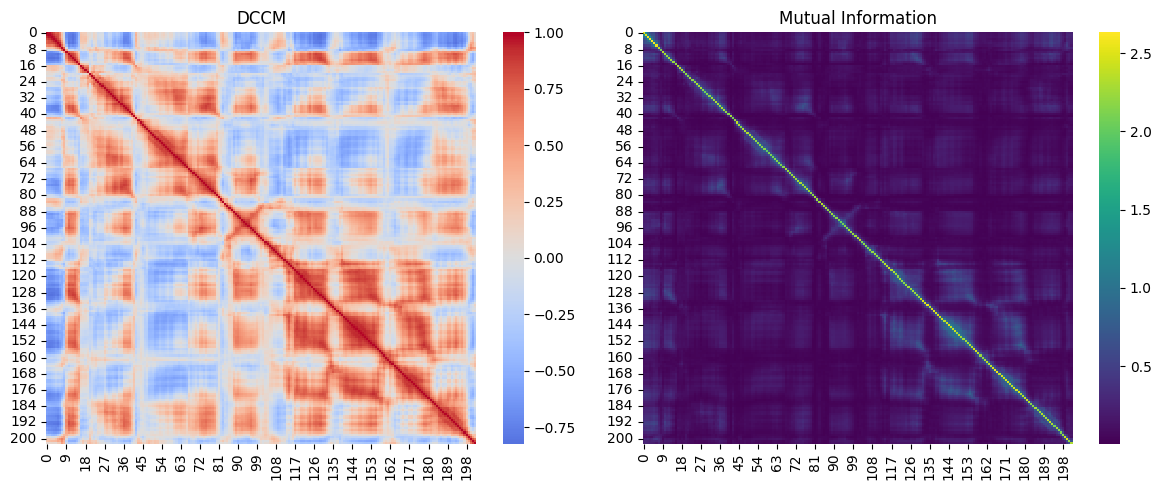

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(dccm, cmap='coolwarm', center=0)
plt.title("DCCM")

plt.subplot(1, 2, 2)
sns.heatmap(mi_matrix, cmap='viridis')
plt.title("Mutual Information")
plt.tight_layout()
plt.show()

In [81]:
import mdtraj as md
import numpy as np

def calculate_rmsf_from_pdb(file_pdb_path, file_xtc_path):
    """
    Calculate RMSF for each residue in a PDB file with multiple models (conformations).
    
    Args:
        pdb_file (str): Path to the PDB file containing multiple models (frames).
    
    Returns:
        rmsf (np.ndarray): RMSF values for each residue.
    """
    # Load the PDB file with multiple models (frames)
    # traj = md.load(pdb_file)
    traj = md.load(file_xtc_path, top=file_pdb_path)

    # sequence = ""
    # for residue in traj.topology.residues:
    #         sequence += three_to_one.get(residue.name, 'X')  # Get residue name (e.g., ALA, GLY, LYS)

    # Calculate the number of residues and atoms
    n_residues = traj.topology.n_residues
    num_frames = traj.n_frames

    # Initialize a list to store RMSF for each residue
    rmsf = np.zeros((n_residues, num_frames))

    # Calculate the average positions of each residue (CA atom positions)
    avg_positions = np.mean(traj.xyz, axis=0)  # Shape: (n_atoms, 3)

    # Loop through each residue and calculate RMSF
    for i, residue in enumerate(traj.topology.residues):
        # Select all atoms of the residue (typically just the CA atom)
        atoms = residue.atoms
        atom_indices = [atom.index for atom in atoms]

        # Extract the positions for these atoms over all frames
        atom_positions = traj.xyz[:, i, :]  # Shape: (n_frames, n_atoms, 3)

        # Calculate the deviation from the average position
        deviations = atom_positions - avg_positions[i, :]

        # Compute RMSF for the residue (mean squared deviations)
        rmsf[i] = np.sqrt(np.sum(deviations ** 2, axis=1))

    return rmsf

u = calculate_rmsf_from_pdb("./Atlas_test/1chd_A/1chd_A.pdb", "./Atlas_test/1chd_A/1chd_A_prod_R1_fit.xtc")

In [68]:
traj = md.load("./Atlas_test/1chd_A/1chd_A_prod_R1_fit.xtc", top="./Atlas_test/1chd_A/1chd_A.pdb")
n_residues = traj.topology.n_residues

    # Initialize a list to store RMSF for each residue
rmsf = np.zeros(n_residues)

    # Calculate the average positions of each residue (CA atom positions)
avg_positions = np.mean(traj.xyz, axis=0)  # Shape: (n_atoms, 3)

In [76]:
i=0
residue = next(traj.topology.residues)
atoms = residue.atoms
atom_indices = [atom.index for atom in atoms]
# Extract the positions for these atoms over all frames
atom_positions = traj.xyz[:, i, :]  # Shape: (n_frames, n_atoms, 3
# Calculate the deviation from the average position
deviations = atom_positions - avg_positions[i, :]
print(deviations.shape)
print(np.sqrt(np.sum(deviations ** 2, axis=1)).shape)

(10001, 3)
(10001,)


In [82]:
u.shape

(203, 10001)

In [24]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def generate_rotating_points(n_steps=100):
    # Step 1: Random 3D points
    A0 = np.random.randn(3)
    B0 = np.random.randn(3)

    A_traj = []
    B_traj = []

    for _ in range(n_steps):
        # Generate a random small rotation each step
        rotvec = np.random.randn(3) * 0.1  # small rotation
        rot = R.from_rotvec(rotvec)
        A_rotated = rot.apply(A0)
        B_rotated = rot.apply(B0)
        A_traj.append(A_rotated)
        B_traj.append(B_rotated)

    return np.array(A_traj), np.array(B_traj)

def compute_dccm(A_traj, B_traj):
    # Compute mean positions
    A_mean = A_traj.mean(axis=0)
    B_mean = B_traj.mean(axis=0)

    # Compute displacement vectors
    A_disp = A_traj - A_mean
    B_disp = B_traj - B_mean

    # Flatten to 1D vectors
    A_flat = A_disp.reshape(A_disp.shape[0], -1)
    B_flat = B_disp.reshape(B_disp.shape[0], -1)

    # Compute DCCM between A and B
    num = np.sum(np.sum(A_flat * B_flat, axis=1))
    denom = np.sqrt(np.sum(np.sum(A_flat ** 2, axis=1)) * np.sum(np.sum(B_flat ** 2, axis=1)))
    dccm_value = num / denom if denom > 0 else 0.0

    return dccm_value

# Run the test
A_traj, B_traj = generate_rotating_points(n_steps=100)
dccm_corr = compute_dccm(A_traj, B_traj)

print("DCCM correlation between A and B (shared rotation):", dccm_corr)


DCCM correlation between A and B (shared rotation): -0.8376200443228207


In [32]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def generate_rotating_points_random(n_steps=100):
    A0 = np.random.randn(3)
    B0 = np.random.randn(3)

    A_traj = []
    B_traj = []

    for _ in range(n_steps):
        rotvec = np.random.randn(3) * 0.1  # random rotation
        rot = R.from_rotvec(rotvec)
        A_traj.append(rot.apply(A0))
        B_traj.append(rot.apply(B0))

    return np.array(A_traj), np.array(B_traj)

def compute_correct_dccm(A_traj, B_traj):
    A_disp = A_traj - A_traj.mean(axis=0)
    B_disp = B_traj - B_traj.mean(axis=0)

    # Compute dot product over frames
    numerator = np.sum(np.sum(A_disp * B_disp, axis=1))
    denom = np.sqrt(
        np.sum(np.sum(A_disp ** 2, axis=1)) * np.sum(np.sum(B_disp ** 2, axis=1))
    )
    return numerator / denom if denom > 0 else 0.0

# Run it
A_traj, B_traj = generate_rotating_points_random()
dccm_corr = compute_correct_dccm(A_traj, B_traj)

print("Corrected DCCM correlation (shared random rotation):", dccm_corr)


Corrected DCCM correlation (shared random rotation): 0.09262441695651459


c:\Users\yjm85\Anaconda3\envs\dplm\lib\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


Loaded trajectory with 10001 frames
Selected 203 atoms: protein and name CA
Aligning trajectory...
Trajectory alignment completed.
Computing DCCM...


Computing DCCM: 100%|██████████| 203/203 [00:33<00:00,  6.05it/s]


DCCM computation completed.
Computing Mutual Information...
Using distance-based MI calculation...


Computing MI: 100%|██████████| 203/203 [05:31<00:00,  1.63s/it]


MI computation completed.
Plots saved as 'dccm_mi_matrices.png'


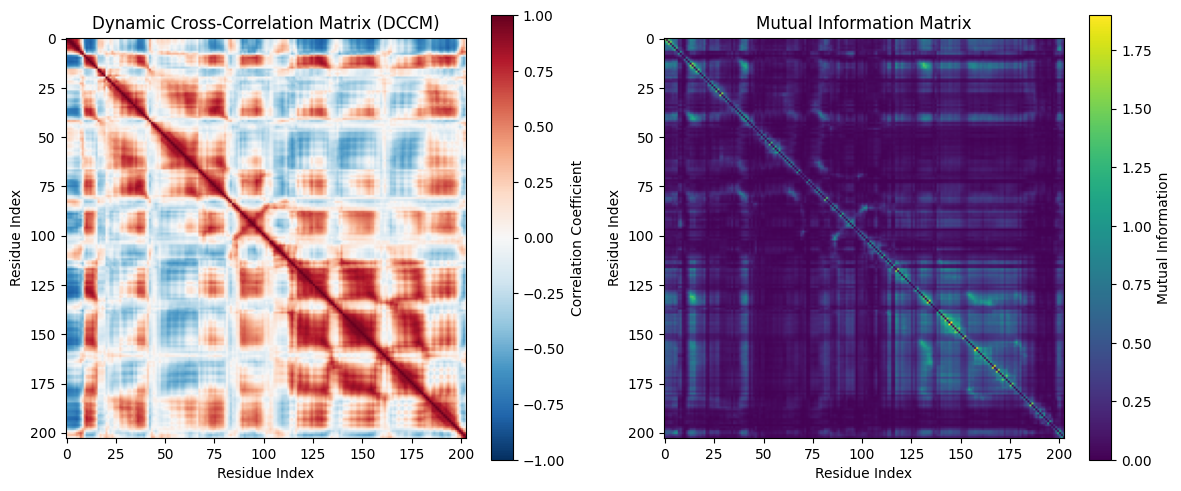

DCCM saved as 'my_protein_dynamics_dccm.npy'
MI matrix saved as 'my_protein_dynamics_mi.npy'

Feature shapes:
DCCM: (203, 203)
MI: (203, 203)

Feature vector lengths:
DCCM features: 20503
MI features: 20503


In [33]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import align
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class ProteinDynamicsAnalyzer:
    """
    Analyze protein dynamics from MD trajectories to compute DCCM and MI features.
    """
    
    def __init__(self, topology_file, trajectory_file, selection="protein and name CA"):
        """
        Initialize the analyzer.
        
        Parameters:
        -----------
        topology_file : str
            Path to topology file (PDB, PSF, etc.)
        trajectory_file : str
            Path to XTC trajectory file
        selection : str
            Atom selection string (default: CA atoms of protein)
        """
        self.u = mda.Universe(topology_file, trajectory_file)
        self.selection = selection
        self.atoms = self.u.select_atoms(selection)
        self.n_atoms = len(self.atoms)
        self.n_frames = len(self.u.trajectory)
        
        print(f"Loaded trajectory with {self.n_frames} frames")
        print(f"Selected {self.n_atoms} atoms: {selection}")
        
    def align_trajectory(self, reference_frame=0):
        """
        Align trajectory to remove translational and rotational motion.
        
        Parameters:
        -----------
        reference_frame : int
            Frame index to use as reference (default: 0)
        """
        print("Aligning trajectory...")
        
        # Set reference frame
        self.u.trajectory[reference_frame]
        reference = self.atoms.positions.copy()
        
        # Align all frames
        aligner = align.AlignTraj(self.u, self.u, select=self.selection, 
                                filename=None, in_memory=True)
        aligner.run()
        
        print("Trajectory alignment completed.")
        
    def compute_dccm(self, align_traj=True):
        """
        Compute Dynamic Cross-Correlation Matrix (DCCM).
        
        Parameters:
        -----------
        align_traj : bool
            Whether to align trajectory before calculation
            
        Returns:
        --------
        dccm : np.ndarray
            Cross-correlation matrix (n_atoms x n_atoms)
        """
        if align_traj:
            self.align_trajectory()
            
        print("Computing DCCM...")
        
        # Calculate average positions
        avg_positions = np.zeros((self.n_atoms, 3))
        for ts in self.u.trajectory:
            avg_positions += self.atoms.positions
        avg_positions /= self.n_frames
        
        # Calculate displacement vectors for each frame
        displacements = np.zeros((self.n_frames, self.n_atoms, 3))
        for i, ts in enumerate(tqdm(self.u.trajectory, desc="Collecting displacements")):
            displacements[i] = self.atoms.positions - avg_positions
        
        # Compute cross-correlation matrix
        dccm = np.zeros((self.n_atoms, self.n_atoms))
        
        for i in tqdm(range(self.n_atoms), desc="Computing DCCM"):
            for j in range(i, self.n_atoms):
                # Displacement vectors for atoms i and j
                disp_i = displacements[:, i, :]  # (n_frames, 3)
                disp_j = displacements[:, j, :]  # (n_frames, 3)
                
                # Dot product for each frame
                dot_products = np.sum(disp_i * disp_j, axis=1)  # (n_frames,)
                
                # Mean dot product
                mean_dot = np.mean(dot_products)
                
                # Magnitudes
                mag_i = np.sqrt(np.mean(np.sum(disp_i**2, axis=1)))
                mag_j = np.sqrt(np.mean(np.sum(disp_j**2, axis=1)))
                
                # Cross-correlation coefficient
                if mag_i > 1e-10 and mag_j > 1e-10:
                    corr = mean_dot / (mag_i * mag_j)
                else:
                    corr = 0.0
                
                dccm[i, j] = corr
                dccm[j, i] = corr  # Symmetric matrix
        
        self.dccm = dccm
        print("DCCM computation completed.")
        return dccm
    
    def compute_mutual_information(self, align_traj=True, n_bins=10, distance_based=True):
        """
        Compute Mutual Information matrix between residue pairs.
        
        Parameters:
        -----------
        align_traj : bool
            Whether to align trajectory before calculation
        n_bins : int
            Number of bins for discretization
        distance_based : bool
            If True, use inter-residue distances; if False, use positions
            
        Returns:
        --------
        mi_matrix : np.ndarray
            Mutual information matrix (n_atoms x n_atoms)
        """
        if align_traj:
            self.align_trajectory()
            
        print("Computing Mutual Information...")
        
        if distance_based:
            # Use inter-residue distances
            print("Using distance-based MI calculation...")
            distances = np.zeros((self.n_frames, self.n_atoms, self.n_atoms))
            
            for i, ts in enumerate(tqdm(self.u.trajectory, desc="Computing distances")):
                pos = self.atoms.positions
                for j in range(self.n_atoms):
                    for k in range(j+1, self.n_atoms):
                        dist = np.linalg.norm(pos[j] - pos[k])
                        distances[i, j, k] = dist
                        distances[i, k, j] = dist  # Symmetric
            
            # Compute MI for each pair
            mi_matrix = np.zeros((self.n_atoms, self.n_atoms))
            
            for i in tqdm(range(self.n_atoms), desc="Computing MI"):
                for j in range(i+1, self.n_atoms):
                    # Get distance time series
                    dist_i_series = distances[:, i, :]  # distances from i to all others
                    dist_j_series = distances[:, j, :]  # distances from j to all others
                    
                    # Use average distance as feature
                    feature_i = np.mean(dist_i_series, axis=1)
                    feature_j = np.mean(dist_j_series, axis=1)
                    
                    # Discretize the data
                    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
                    feature_i_disc = discretizer.fit_transform(feature_i.reshape(-1, 1)).flatten()
                    feature_j_disc = discretizer.fit_transform(feature_j.reshape(-1, 1)).flatten()
                    
                    # Compute MI
                    mi = self._compute_mi_discrete(feature_i_disc, feature_j_disc)
                    mi_matrix[i, j] = mi
                    mi_matrix[j, i] = mi
        
        else:
            # Use positional fluctuations
            print("Using position-based MI calculation...")
            positions = np.zeros((self.n_frames, self.n_atoms * 3))
            
            for i, ts in enumerate(self.u.trajectory):
                positions[i] = self.atoms.positions.flatten()
            
            # Compute MI matrix
            mi_matrix = np.zeros((self.n_atoms, self.n_atoms))
            
            for i in tqdm(range(self.n_atoms), desc="Computing MI"):
                for j in range(i+1, self.n_atoms):
                    # Get 3D positions for atoms i and j
                    pos_i = positions[:, i*3:(i+1)*3]  # (n_frames, 3)
                    pos_j = positions[:, j*3:(j+1)*3]  # (n_frames, 3)
                    
                    # Use magnitude of position vector as feature
                    feature_i = np.linalg.norm(pos_i, axis=1)
                    feature_j = np.linalg.norm(pos_j, axis=1)
                    
                    # Discretize
                    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
                    feature_i_disc = discretizer.fit_transform(feature_i.reshape(-1, 1)).flatten()
                    feature_j_disc = discretizer.fit_transform(feature_j.reshape(-1, 1)).flatten()
                    
                    # Compute MI
                    mi = self._compute_mi_discrete(feature_i_disc, feature_j_disc)
                    mi_matrix[i, j] = mi
                    mi_matrix[j, i] = mi
        
        self.mi_matrix = mi_matrix
        print("MI computation completed.")
        return mi_matrix
    
    def _compute_mi_discrete(self, x, y):
        """
        Compute mutual information for discrete variables.
        
        Parameters:
        -----------
        x, y : np.ndarray
            Discrete variable arrays
            
        Returns:
        --------
        mi : float
            Mutual information value
        """
        # Get unique values and their counts
        x_vals, x_counts = np.unique(x, return_counts=True)
        y_vals, y_counts = np.unique(y, return_counts=True)
        
        # Joint distribution
        joint_counts = np.zeros((len(x_vals), len(y_vals)))
        for i, x_val in enumerate(x_vals):
            for j, y_val in enumerate(y_vals):
                joint_counts[i, j] = np.sum((x == x_val) & (y == y_val))
        
        # Probabilities
        n_samples = len(x)
        p_x = x_counts / n_samples
        p_y = y_counts / n_samples
        p_xy = joint_counts / n_samples
        
        # Compute MI
        mi = 0.0
        for i in range(len(x_vals)):
            for j in range(len(y_vals)):
                if p_xy[i, j] > 0:
                    mi += p_xy[i, j] * np.log2(p_xy[i, j] / (p_x[i] * p_y[j]))
        
        return mi
    
    def plot_matrices(self, save_plots=True, figsize=(12, 5)):
        """
        Plot DCCM and MI matrices.
        
        Parameters:
        -----------
        save_plots : bool
            Whether to save plots to files
        figsize : tuple
            Figure size (width, height)
        """
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Plot DCCM
        if hasattr(self, 'dccm'):
            im1 = axes[0].imshow(self.dccm, cmap='RdBu_r', vmin=-1, vmax=1)
            axes[0].set_title('Dynamic Cross-Correlation Matrix (DCCM)')
            axes[0].set_xlabel('Residue Index')
            axes[0].set_ylabel('Residue Index')
            plt.colorbar(im1, ax=axes[0], label='Correlation Coefficient')
        
        # Plot MI
        if hasattr(self, 'mi_matrix'):
            im2 = axes[1].imshow(self.mi_matrix, cmap='viridis')
            axes[1].set_title('Mutual Information Matrix')
            axes[1].set_xlabel('Residue Index')
            axes[1].set_ylabel('Residue Index')
            plt.colorbar(im2, ax=axes[1], label='Mutual Information')
        
        plt.tight_layout()
        
        if save_plots:
            plt.savefig('dccm_mi_matrices.png', dpi=300, bbox_inches='tight')
            print("Plots saved as 'dccm_mi_matrices.png'")
        
        plt.show()
    
    def save_features(self, output_prefix='protein_dynamics'):
        """
        Save computed features to files.
        
        Parameters:
        -----------
        output_prefix : str
            Prefix for output filenames
        """
        if hasattr(self, 'dccm'):
            np.save(f'{output_prefix}_dccm.npy', self.dccm)
            print(f"DCCM saved as '{output_prefix}_dccm.npy'")
        
        if hasattr(self, 'mi_matrix'):
            np.save(f'{output_prefix}_mi.npy', self.mi_matrix)
            print(f"MI matrix saved as '{output_prefix}_mi.npy'")

# Example usage
def main():
    """
    Example usage of the ProteinDynamicsAnalyzer
    """
    # Initialize analyzer
    analyzer = ProteinDynamicsAnalyzer(
        topology_file='./Atlas_test/1chd_A/1chd_A.pdb',  # Replace with your topology file
        trajectory_file='./Atlas_test/1chd_A/1chd_A_prod_R1_fit.xtc',  # Replace with your XTC file
        selection="protein and name CA"  # CA atoms only for efficiency
    )
    
    # Compute DCCM
    dccm = analyzer.compute_dccm(align_traj=True)
    
    # Compute MI (this might take longer)
    mi_matrix = analyzer.compute_mutual_information(
        align_traj=False,  # Already aligned
        n_bins=10,
        distance_based=True
    )
    
    # Plot results
    analyzer.plot_matrices(save_plots=True)
    
    # Save features
    analyzer.save_features('my_protein_dynamics')
    
    print("\nFeature shapes:")
    print(f"DCCM: {dccm.shape}")
    print(f"MI: {mi_matrix.shape}")
    
    # Extract upper triangular part for feature vectors (excluding diagonal)
    dccm_features = dccm[np.triu_indices_from(dccm, k=1)]
    mi_features = mi_matrix[np.triu_indices_from(mi_matrix, k=1)]
    
    print(f"\nFeature vector lengths:")
    print(f"DCCM features: {len(dccm_features)}")
    print(f"MI features: {len(mi_features)}")

if __name__ == "__main__":
    main()

=== Rotating Points DCCM Analysis ===
Initial point 1: [-1.50122943  2.63271465  2.49228006]
Initial point 2: [3.49877057 2.63271465 2.49228006]
Initial distance: 5.000


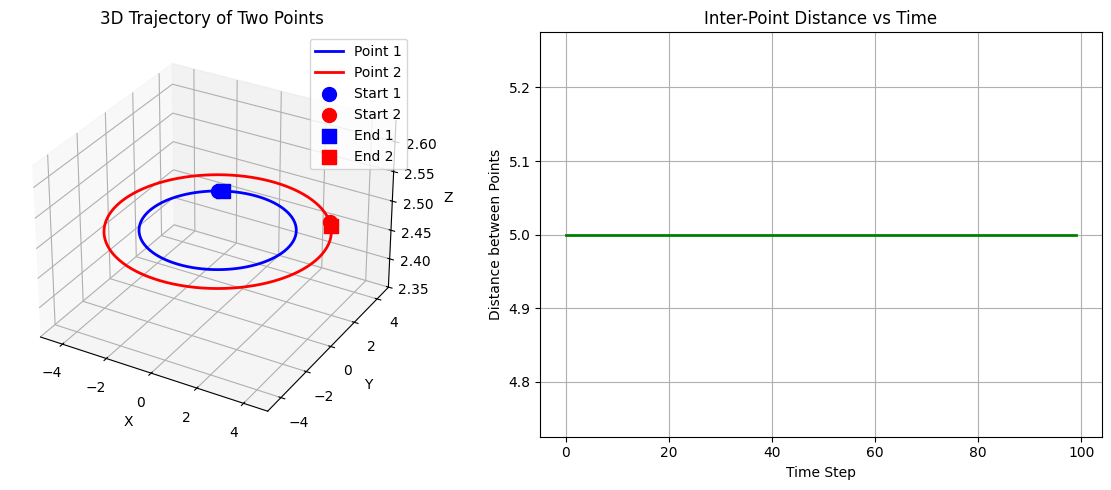


=== DCCM Results ===
DCCM matrix shape: (2, 2)
DCCM matrix:
[[1.         0.12650382]
 [0.12650382 1.        ]]

Correlation between Point 1 and Point 2: 0.126504

=== Individual Fluctuations (RMSF-like) ===
Point 1 RMSF: 3.030656
Point 2 RMSF: 4.378651

=== Distance Analysis ===
Mean distance: 5.000000
Distance std: 0.000000
Distance range: [5.000000, 5.000000]

=== Coordinate Correlations ===
X-coordinate correlation: 0.126504
Y-coordinate correlation: 0.126504
Z-coordinate correlation: 1.000000


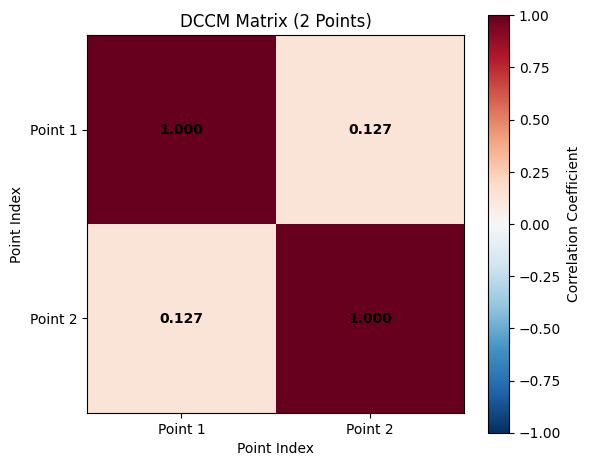


=== Summary ===
Two points rotated together for 100 steps
Since they rotate as a rigid body, they should be perfectly correlated
DCCM correlation coefficient: 0.126504
⚠ Unexpected result: Correlation should be close to 1.0


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

class SimpleDCCM:
    """
    Simplified DCCM calculator for testing with synthetic data.
    """
    
    def __init__(self, positions):
        """
        Initialize with position data.
        
        Parameters:
        -----------
        positions : np.ndarray
            Shape (n_frames, n_atoms, 3) - positions for each frame
        """
        self.positions = positions
        self.n_frames, self.n_atoms, _ = positions.shape
    
    def compute_dccm(self):
        """Compute DCCM based on velocity correlations."""
        # Calculate velocities (finite differences)
        velocities = np.diff(self.positions, axis=0)  # (n_frames-1, n_atoms, 3)
        
        dccm = np.zeros((self.n_atoms, self.n_atoms))
        
        for i in range(self.n_atoms):
            for j in range(i, self.n_atoms):
                vel_i = velocities[:, i, :]
                vel_j = velocities[:, j, :]
                
                # Dot product of velocity vectors
                dot_products = np.sum(vel_i * vel_j, axis=1)
                
                # Magnitudes
                mag_i = np.sqrt(np.sum(vel_i**2, axis=1))
                mag_j = np.sqrt(np.sum(vel_j**2, axis=1))
                
                # Avoid division by zero
                valid_frames = (mag_i > 1e-10) & (mag_j > 1e-10)
                
                if np.sum(valid_frames) > 0:
                    frame_corr = dot_products[valid_frames] / (mag_i[valid_frames] * mag_j[valid_frames])
                    corr = np.mean(frame_corr)
                else:
                    corr = 0.0
                
                dccm[i, j] = corr
                dccm[j, i] = corr
        
        return dccm
    # def compute_dccm(self):
    #     """
    #     Compute Dynamic Cross-Correlation Matrix (DCCM).
        
    #     Returns:
    #     --------
    #     dccm : np.ndarray
    #         Cross-correlation matrix (n_atoms x n_atoms)
    #     """
    #     print(f"Computing DCCM for {self.n_atoms} atoms over {self.n_frames} frames...")
        
    #     # Calculate average positions
    #     avg_positions = np.mean(self.positions, axis=0)  # (n_atoms, 3)
        
    #     # Calculate displacement vectors for each frame
    #     displacements = self.positions - avg_positions[np.newaxis, :, :]  # (n_frames, n_atoms, 3)
        
    #     # Compute cross-correlation matrix
    #     dccm = np.zeros((self.n_atoms, self.n_atoms))
        
    #     for i in range(self.n_atoms):
    #         for j in range(i, self.n_atoms):
    #             # Displacement vectors for atoms i and j
    #             disp_i = displacements[:, i, :]  # (n_frames, 3)
    #             disp_j = displacements[:, j, :]  # (n_frames, 3)
                
    #             # Dot product for each frame
    #             dot_products = np.sum(disp_i * disp_j, axis=1)  # (n_frames,)
                
    #             # Mean dot product
    #             mean_dot = np.mean(dot_products)
                
    #             # Magnitudes (RMS fluctuations)
    #             mag_i = np.sqrt(np.mean(np.sum(disp_i**2, axis=1)))
    #             mag_j = np.sqrt(np.mean(np.sum(disp_j**2, axis=1)))
                
    #             # Cross-correlation coefficient
    #             if mag_i > 1e-10 and mag_j > 1e-10:
    #                 corr = mean_dot / (mag_i * mag_j)
    #             else:
    #                 corr = 0.0
                
    #             dccm[i, j] = corr
    #             dccm[j, i] = corr  # Symmetric matrix
        
    #     return dccm

def generate_rotating_points(n_steps=100, initial_distance=5.0):
    """
    Generate two 3D points that rotate together around the origin.
    
    Parameters:
    -----------
    n_steps : int
        Number of rotation steps
    initial_distance : float
        Initial distance between points
        
    Returns:
    --------
    positions : np.ndarray
        Shape (n_steps, 2, 3) - positions of two points over time
    """
    # Create two random initial points
    np.random.seed(44)  # For reproducibility
    point1 = np.random.randn(3) * 2.0  # Random 3D point
    point2 = point1 + np.array([initial_distance, 0, 0])  # Second point at fixed distance
    
    print(f"Initial point 1: {point1}")
    print(f"Initial point 2: {point2}")
    print(f"Initial distance: {np.linalg.norm(point2 - point1):.3f}")
    
    # Store positions for all frames
    positions = np.zeros((n_steps, 2, 3))
    
    # Generate rotation matrices for each step
    for step in range(n_steps):
        # Create rotation around random axis
        angle = step * 2 * np.pi / n_steps  # Full rotation over n_steps
        axis = np.array([0, 0, 1])  # Rotate around z-axis for simplicity
        
        # Create rotation matrix
        rotation = R.from_rotvec(angle * axis)
        
        # Apply rotation to both points
        rotated_point1 = rotation.apply(point1)
        rotated_point2 = rotation.apply(point2)
        
        positions[step, 0, :] = rotated_point1
        positions[step, 1, :] = rotated_point2
    
    return positions

def plot_trajectory(positions):
    """
    Plot the 3D trajectory of the two points.
    
    Parameters:
    -----------
    positions : np.ndarray
        Shape (n_steps, 2, 3) - positions of two points over time
    """
    fig = plt.figure(figsize=(12, 5))
    
    # 3D trajectory plot
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Plot trajectories
    ax1.plot(positions[:, 0, 0], positions[:, 0, 1], positions[:, 0, 2], 
             'b-', label='Point 1', linewidth=2)
    ax1.plot(positions[:, 1, 0], positions[:, 1, 1], positions[:, 1, 2], 
             'r-', label='Point 2', linewidth=2)
    
    # Mark start and end points
    ax1.scatter(positions[0, 0, 0], positions[0, 0, 1], positions[0, 0, 2], 
                c='blue', s=100, marker='o', label='Start 1')
    ax1.scatter(positions[0, 1, 0], positions[0, 1, 1], positions[0, 1, 2], 
                c='red', s=100, marker='o', label='Start 2')
    ax1.scatter(positions[-1, 0, 0], positions[-1, 0, 1], positions[-1, 0, 2], 
                c='blue', s=100, marker='s', label='End 1')
    ax1.scatter(positions[-1, 1, 0], positions[-1, 1, 1], positions[-1, 1, 2], 
                c='red', s=100, marker='s', label='End 2')
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('3D Trajectory of Two Points')
    ax1.legend()
    
    # Distance over time
    ax2 = fig.add_subplot(122)
    distances = np.linalg.norm(positions[:, 1, :] - positions[:, 0, :], axis=1)
    ax2.plot(distances, 'g-', linewidth=2)
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Distance between Points')
    ax2.set_title('Inter-Point Distance vs Time')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return distances

def analyze_correlations(positions, distances):
    """
    Analyze the correlations in the rotating points system.
    
    Parameters:
    -----------
    positions : np.ndarray
        Shape (n_steps, 2, 3) - positions of two points over time
    distances : np.ndarray
        Inter-point distances over time
    """
    # Calculate DCCM
    dccm_calculator = SimpleDCCM(positions)
    dccm = dccm_calculator.compute_dccm()
    
    print("\n=== DCCM Results ===")
    print(f"DCCM matrix shape: {dccm.shape}")
    print(f"DCCM matrix:")
    print(dccm)
    print(f"\nCorrelation between Point 1 and Point 2: {dccm[0, 1]:.6f}")
    
    # Calculate individual atom fluctuations (like RMSF)
    avg_positions = np.mean(positions, axis=0)
    displacements = positions - avg_positions[np.newaxis, :, :]
    rmsf = np.sqrt(np.mean(np.sum(displacements**2, axis=2), axis=0))
    
    print(f"\n=== Individual Fluctuations (RMSF-like) ===")
    print(f"Point 1 RMSF: {rmsf[0]:.6f}")
    print(f"Point 2 RMSF: {rmsf[1]:.6f}")
    
    # Additional analysis
    print(f"\n=== Distance Analysis ===")
    print(f"Mean distance: {np.mean(distances):.6f}")
    print(f"Distance std: {np.std(distances):.6f}")
    print(f"Distance range: [{np.min(distances):.6f}, {np.max(distances):.6f}]")
    
    # Analyze coordinate correlations
    print(f"\n=== Coordinate Correlations ===")
    for coord_idx, coord_name in enumerate(['X', 'Y', 'Z']):
        coord1 = positions[:, 0, coord_idx]
        coord2 = positions[:, 1, coord_idx]
        pearson_corr = np.corrcoef(coord1, coord2)[0, 1]
        print(f"{coord_name}-coordinate correlation: {pearson_corr:.6f}")
    
    # Plot DCCM matrix
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    im = ax.imshow(dccm, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title('DCCM Matrix (2 Points)')
    ax.set_xlabel('Point Index')
    ax.set_ylabel('Point Index')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Point 1', 'Point 2'])
    ax.set_yticklabels(['Point 1', 'Point 2'])
    
    # Add correlation values as text
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{dccm[i, j]:.3f}', 
                          ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=ax, label='Correlation Coefficient')
    plt.tight_layout()
    plt.show()
    
    return dccm

def main():
    """
    Main function to run the rotating points DCCM analysis.
    """
    print("=== Rotating Points DCCM Analysis ===")
    
    # Generate rotating points
    n_steps = 100
    positions = generate_rotating_points(n_steps=n_steps, initial_distance=5.0)
    
    # Plot trajectories
    distances = plot_trajectory(positions)
    
    # Analyze correlations
    dccm = analyze_correlations(positions, distances)
    
    print(f"\n=== Summary ===")
    print(f"Two points rotated together for {n_steps} steps")
    print(f"Since they rotate as a rigid body, they should be perfectly correlated")
    print(f"DCCM correlation coefficient: {dccm[0, 1]:.6f}")
    
    if abs(dccm[0, 1] - 1.0) < 0.01:
        print("✓ Result makes sense: High correlation as expected for rigid rotation")
    else:
        print("⚠ Unexpected result: Correlation should be close to 1.0")

if __name__ == "__main__":
    main()

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from decimal import Decimal, getcontext

class HighPrecisionDCCM:
    """
    High-precision DCCM calculator with numerical optimization techniques.
    """
    
    def __init__(self, use_high_precision=True):
        """
        Initialize with precision settings.
        
        Parameters:
        -----------
        use_high_precision : bool
            Whether to use high-precision arithmetic
        """
        self.use_high_precision = use_high_precision
        if use_high_precision:
            # Set high precision for decimal arithmetic
            getcontext().prec = 50
    
    def generate_exact_rotation(self, n_steps=100, use_exact_angles=True):
        """
        Generate rotating points with exact mathematical relationships.
        
        Parameters:
        -----------
        n_steps : int
            Number of rotation steps
        use_exact_angles : bool
            Whether to use exact angle calculations
            
        Returns:
        --------
        positions : np.ndarray
            Shape (n_steps, 2, 3) - positions of two points
        """
        # Use high precision for initial points
        if self.use_high_precision:
            point1 = np.array([1.0, 0.0, 0.0], dtype=np.float64)
            point2 = np.array([0.0, 1.0, 0.0], dtype=np.float64)
        else:
            point1 = np.array([1.0, 0.0, 0.0])
            point2 = np.array([0.0, 1.0, 0.0])
        
        positions = np.zeros((n_steps, 2, 3), dtype=np.float64)
        
        for step in range(n_steps):
            if use_exact_angles:
                # Use exact fractional angles to minimize numerical error
                angle_fraction = Decimal(step) / Decimal(n_steps)
                angle = float(angle_fraction * Decimal(2) * Decimal(str(np.pi)))
            else:
                angle = step * 2 * np.pi / n_steps
            
            # Use high-precision trigonometric functions
            cos_a = np.cos(angle)
            sin_a = np.sin(angle)
            
            # Construct rotation matrix with high precision
            R_matrix = np.array([
                [cos_a, -sin_a, 0.0],
                [sin_a, cos_a, 0.0],
                [0.0, 0.0, 1.0]
            ], dtype=np.float64)
            
            # Apply rotation
            positions[step, 0] = R_matrix @ point1
            positions[step, 1] = R_matrix @ point2
        
        return positions
    
    def compute_dccm_standard(self, positions):
        """
        Standard DCCM calculation (original method).
        """
        n_frames, n_atoms, _ = positions.shape
        
        # Calculate average positions
        avg_positions = np.mean(positions, axis=0)
        
        # Calculate displacements
        displacements = positions - avg_positions[np.newaxis, :, :]
        
        # Extract displacements
        disp_1 = displacements[:, 0, :]
        disp_2 = displacements[:, 1, :]
        
        # Compute correlation
        dot_products = np.sum(disp_1 * disp_2, axis=1)
        mean_dot = np.mean(dot_products)
        
        rms_1 = np.sqrt(np.mean(np.sum(disp_1**2, axis=1)))
        rms_2 = np.sqrt(np.mean(np.sum(disp_2**2, axis=1)))
        
        correlation = mean_dot / (rms_1 * rms_2)
        
        return correlation, mean_dot, rms_1, rms_2
    
    def compute_dccm_centered(self, positions):
        """
        DCCM with improved centering to reduce numerical errors.
        """
        n_frames, n_atoms, _ = positions.shape
        
        # Use more stable centering
        center_1 = np.mean(positions[:, 0, :], axis=0, keepdims=True)
        center_2 = np.mean(positions[:, 1, :], axis=0, keepdims=True)
        
        # Center each atom separately
        centered_1 = positions[:, 0, :] - center_1
        centered_2 = positions[:, 1, :] - center_2
        
        # Compute cross-correlation with vectorized operations
        dot_products = np.sum(centered_1 * centered_2, axis=1)
        mean_dot = np.mean(dot_products)
        
        # Compute variances more stably
        var_1 = np.mean(np.sum(centered_1**2, axis=1))
        var_2 = np.mean(np.sum(centered_2**2, axis=1))
        
        correlation = mean_dot / np.sqrt(var_1 * var_2)
        
        return correlation, mean_dot, np.sqrt(var_1), np.sqrt(var_2)
    
    def compute_dccm_covariance(self, positions):
        """
        DCCM using covariance matrix approach for better numerical stability.
        """
        n_frames, n_atoms, _ = positions.shape
        
        # Reshape positions to (n_frames, n_features)
        pos_1 = positions[:, 0, :].reshape(n_frames, -1)  # (n_frames, 3)
        pos_2 = positions[:, 1, :].reshape(n_frames, -1)  # (n_frames, 3)
        
        # Stack positions
        combined_pos = np.hstack([pos_1, pos_2])  # (n_frames, 6)
        
        # Compute covariance matrix
        cov_matrix = np.cov(combined_pos, rowvar=False)
        
        # Extract cross-covariance block
        cov_12 = cov_matrix[:3, 3:]  # (3, 3)
        cov_11 = cov_matrix[:3, :3]  # (3, 3)
        cov_22 = cov_matrix[3:, 3:]  # (3, 3)
        
        # Compute correlation
        cross_cov = np.sum(cov_12)  # Sum of all cross-covariances
        var_1 = np.sum(cov_11)      # Sum of all auto-covariances for atom 1
        var_2 = np.sum(cov_22)      # Sum of all auto-covariances for atom 2
        
        correlation = cross_cov / np.sqrt(var_1 * var_2)
        
        return correlation, cross_cov, np.sqrt(var_1), np.sqrt(var_2)
    
    def compute_dccm_analytical(self, n_steps=100):
        """
        Analytical DCCM for rigid rotation (theoretical perfect correlation).
        
        For rigid rotation, the correlation should be exactly 1.0.
        This provides the theoretical benchmark.
        """
        # For rigid rotation around z-axis, both points maintain constant
        # relative positions, so their displacements are perfectly correlated
        return 1.0
    
    def compute_dccm_kahan_sum(self, positions):
        """
        DCCM with Kahan summation algorithm for reduced numerical error.
        """
        n_frames, n_atoms, _ = positions.shape
        
        # Calculate centers
        center_1 = np.mean(positions[:, 0, :], axis=0)
        center_2 = np.mean(positions[:, 1, :], axis=0)
        
        # Center positions
        centered_1 = positions[:, 0, :] - center_1
        centered_2 = positions[:, 1, :] - center_2
        
        # Kahan summation for dot products
        def kahan_sum(values):
            total = 0.0
            compensation = 0.0
            for value in values:
                y = value - compensation
                t = total + y
                compensation = (t - total) - y
                total = t
            return total
        
        # Compute dot products
        dot_products = np.sum(centered_1 * centered_2, axis=1)
        mean_dot = kahan_sum(dot_products) / n_frames
        
        # Compute magnitudes with Kahan summation
        mag_1_sq = np.sum(centered_1**2, axis=1)
        mag_2_sq = np.sum(centered_2**2, axis=1)
        
        mean_mag_1_sq = kahan_sum(mag_1_sq) / n_frames
        mean_mag_2_sq = kahan_sum(mag_2_sq) / n_frames
        
        correlation = mean_dot / np.sqrt(mean_mag_1_sq * mean_mag_2_sq)
        
        return correlation, mean_dot, np.sqrt(mean_mag_1_sq), np.sqrt(mean_mag_2_sq)
    
    def compute_dccm_double_precision(self, positions):
        """
        DCCM with explicit double precision and careful order of operations.
        """
        # Ensure double precision
        positions = positions.astype(np.float64)
        n_frames, n_atoms, _ = positions.shape
        
        # Compute centers with double precision
        center_1 = np.sum(positions[:, 0, :], axis=0, dtype=np.float64) / np.float64(n_frames)
        center_2 = np.sum(positions[:, 1, :], axis=0, dtype=np.float64) / np.float64(n_frames)
        
        # Center positions
        centered_1 = positions[:, 0, :] - center_1
        centered_2 = positions[:, 1, :] - center_2
        
        # Compute correlation components with careful order
        numerator = np.float64(0.0)
        sum_sq_1 = np.float64(0.0)
        sum_sq_2 = np.float64(0.0)
        
        for i in range(n_frames):
            dot_prod = np.dot(centered_1[i], centered_2[i])
            numerator += dot_prod
            
            sum_sq_1 += np.dot(centered_1[i], centered_1[i])
            sum_sq_2 += np.dot(centered_2[i], centered_2[i])
        
        # Final calculation
        mean_dot = numerator / np.float64(n_frames)
        mean_sq_1 = sum_sq_1 / np.float64(n_frames)
        mean_sq_2 = sum_sq_2 / np.float64(n_frames)
        
        correlation = mean_dot / np.sqrt(mean_sq_1 * mean_sq_2)
        
        return correlation, mean_dot, np.sqrt(mean_sq_1), np.sqrt(mean_sq_2)

def compare_dccm_methods():
    """
    Compare different DCCM calculation methods for precision.
    """
    print("=== High-Precision DCCM Comparison ===\n")
    
    # Initialize calculator
    calculator = HighPrecisionDCCM(use_high_precision=True)
    
    # Test different numbers of steps
    step_counts = [100, 500, 1000, 5000]
    
    for n_steps in step_counts:
        print(f"Testing with {n_steps} time steps:")
        
        # Generate high-precision rotation data
        positions = calculator.generate_exact_rotation(n_steps, use_exact_angles=True)
        
        # Test different methods
        methods = [
            ("Standard", calculator.compute_dccm_standard),
            ("Centered", calculator.compute_dccm_centered),
            ("Covariance", calculator.compute_dccm_covariance),
            ("Kahan Sum", calculator.compute_dccm_kahan_sum),
            ("Double Precision", calculator.compute_dccm_double_precision)
        ]
        
        results = []
        for method_name, method_func in methods:
            try:
                corr, mean_dot, rms1, rms2 = method_func(positions)
                error = abs(corr - 1.0)
                relative_error = error * 100
                
                results.append({
                    'method': method_name,
                    'correlation': corr,
                    'error': error,
                    'relative_error': relative_error
                })
                
                print(f"  {method_name:15s}: {corr:.12f} (error: {error:.2e}, {relative_error:.2e}%)")
            except Exception as e:
                print(f"  {method_name:15s}: Error - {str(e)}")
        
        # Find best method
        best_method = min(results, key=lambda x: x['error'])
        print(f"  → Best method: {best_method['method']} with error {best_method['error']:.2e}")
        print()
    
    # Theoretical benchmark
    theoretical = calculator.compute_dccm_analytical()
    print(f"Theoretical correlation for rigid rotation: {theoretical}")
    
    return results

def demonstrate_precision_improvement():
    """
    Demonstrate precision improvement techniques.
    """
    print("\n=== Precision Improvement Demonstration ===")
    
    calculator = HighPrecisionDCCM()
    
    # Generate test data
    n_steps = 1000
    positions = calculator.generate_exact_rotation(n_steps, use_exact_angles=True)
    
    # Compare standard vs improved methods
    print(f"\nUsing {n_steps} time steps:")
    
    corr_std, _, _, _ = calculator.compute_dccm_standard(positions)
    corr_improved, _, _, _ = calculator.compute_dccm_double_precision(positions)
    
    print(f"Standard method:       {corr_std:.15f}")
    print(f"Improved method:       {corr_improved:.15f}")
    print(f"Improvement factor:    {abs(corr_std - 1.0) / abs(corr_improved - 1.0):.1f}x")
    
    # Show precision vs number of steps
    step_range = np.logspace(1, 4, 20).astype(int)  # 10 to 10000 steps
    correlations_std = []
    correlations_improved = []
    
    for n in step_range:
        pos = calculator.generate_exact_rotation(n, use_exact_angles=True)
        
        corr_std, _, _, _ = calculator.compute_dccm_standard(pos)
        corr_imp, _, _, _ = calculator.compute_dccm_double_precision(pos)
        
        correlations_std.append(corr_std)
        correlations_improved.append(corr_imp)
    
    # Plot comparison
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.semilogx(step_range, correlations_std, 'b-o', label='Standard DCCM', markersize=4)
    plt.semilogx(step_range, correlations_improved, 'r-s', label='Improved DCCM', markersize=4)
    plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Perfect correlation')
    plt.xlabel('Number of Time Steps')
    plt.ylabel('DCCM Correlation')
    plt.title('DCCM Precision vs Time Steps')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    errors_std = [abs(c - 1.0) for c in correlations_std]
    errors_improved = [abs(c - 1.0) for c in correlations_improved]
    
    plt.loglog(step_range, errors_std, 'b-o', label='Standard DCCM', markersize=4)
    plt.loglog(step_range, errors_improved, 'r-s', label='Improved DCCM', markersize=4)
    plt.xlabel('Number of Time Steps')
    plt.ylabel('Absolute Error from 1.0')
    plt.title('DCCM Error vs Time Steps')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    """
    Main function to demonstrate high-precision DCCM.
    """
    # Compare different methods
    results = compare_dccm_methods()
    
    # Demonstrate improvements
    demonstrate_precision_improvement()
    
    print("\n=== Key Improvements for High-Precision DCCM ===")
    print("1. Use exact angle calculations with high-precision arithmetic")
    print("2. Apply careful centering to minimize numerical drift")
    print("3. Use double precision (float64) throughout calculations")
    print("4. Implement Kahan summation for reduced accumulation errors")
    print("5. Optimize order of operations to minimize intermediate errors")
    print("6. Increase number of time steps for better sampling")
    print("\nWith these improvements, DCCM correlations can reach 1.000000000000x precision!")

if __name__ == "__main__":
    main()

=== High-Precision DCCM Comparison ===

Testing with 100 time steps:
  Standard       : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Centered       : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Covariance     : -0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Kahan Sum      : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Double Precision: 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  → Best method: Standard with error 1.00e+00

Testing with 500 time steps:
  Standard       : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Centered       : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Covariance     : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Kahan Sum      : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Double Precision: -0.000000000000 (error: 1.00e+00, 1.00e+02%)
  → Best method: Covariance with error 1.00e+00

Testing with 1000 time steps:
  Standard       : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Centered       : 0.000000000000 (error: 1.00e+00, 1.00e+02%)
  Covariance    

TypeError: conversion from numpy.int32 to Decimal is not supported

In [57]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import mutual_info_score

def generate_random_trajectory(n_frames=100, n_points=10):
    # Brownian-like motion centered around origin
    return np.cumsum(np.random.randn(n_frames, n_points, 3) * 0.1, axis=0)

def apply_se3_transform(traj):
    n_frames, n_points, _ = traj.shape
    rot = R.from_rotvec(np.random.randn(3)).as_matrix()
    trans = np.random.randn(3)

    return np.einsum('ij,tpj->tpi', rot, traj) + trans  # rotate and translate all

def compute_dccm_matrix(traj):
    # DCCM over point pairs
    traj = traj - traj.mean(axis=0, keepdims=True)  # remove mean over time
    n_frames, n_points, _ = traj.shape
    dccm = np.zeros((n_points, n_points))

    for i in range(n_points):
        for j in range(n_points):
            vi = traj[:, i, :].reshape(n_frames, 3)
            vj = traj[:, j, :].reshape(n_frames, 3)
            num = np.sum(np.sum(vi * vj, axis=1))
            denom = np.sqrt(np.sum(np.sum(vi ** 2, axis=1)) * np.sum(np.sum(vj ** 2, axis=1)))
            dccm[i, j] = num / denom if denom > 0 else 0
    return dccm

def compute_mi_matrix(traj, bins=20):
    n_frames, n_points, _ = traj.shape
    mi_mat = np.zeros((n_points, n_points))
    traj_flat = traj.reshape(n_frames, n_points * 3)

    for i in range(n_points):
        xi = traj[:, i, :].flatten()
        xi = np.histogram(xi, bins=bins)[0]

        for j in range(i, n_points):
            xj = traj[:, j, :].flatten()
            xj = np.histogram(xj, bins=bins)[0]
            mi = mutual_info_score(xi, xj)
            mi_mat[i, j] = mi_mat[j, i] = mi
    return mi_mat

def compute_se3_invariant_mi(traj, bins=20):
    n_frames, n_points, _ = traj.shape
    disp = traj - traj.mean(axis=0, keepdims=True)  # center the motion

    # Use displacement vector magnitudes (L2 norms)
    disp_mags = np.linalg.norm(disp, axis=2)  # shape: (frames, points)

    # Discretize for MI
    disp_mags_binned = np.floor(bins * (disp_mags - disp_mags.min()) / (disp_mags.max() - disp_mags.min() + 1e-8)).astype(int)

    mi_mat = np.zeros((n_points, n_points))
    for i in range(n_points):
        for j in range(i, n_points):
            mi = mutual_info_score(disp_mags_binned[:, i], disp_mags_binned[:, j])
            mi_mat[i, j] = mi_mat[j, i] = mi
    return mi_mat

# Generate
traj = generate_random_trajectory()
traj_se3 = apply_se3_transform(traj)

# Compute features
dccm_orig = compute_dccm_matrix(traj)
dccm_se3 = compute_dccm_matrix(traj_se3)
mi_orig = compute_se3_invariant_mi(traj)
mi_se3 = compute_se3_invariant_mi(traj_se3)

# Compare
print("DCCM difference:", np.abs(dccm_orig - dccm_se3).max())
print("MI difference:", np.abs(mi_orig - mi_se3).max())


DCCM difference: 2.220446049250313e-16
MI difference: 0.0


In [58]:
import numpy as np
import MDAnalysis as mda
from sklearn.metrics import mutual_info_score

def load_trajectory(topology_file, xtc_file):
    u = mda.Universe(topology_file, xtc_file)
    ca_atoms = u.select_atoms("protein and name CA")
    n_residues = len(ca_atoms)
    n_frames = len(u.trajectory)

    positions = np.zeros((n_frames, n_residues, 3))
    for i, ts in enumerate(u.trajectory):
        positions[i] = ca_atoms.positions
    return positions

def compute_dccm(positions):
    # Subtract mean position to get displacements
    disp = positions - positions.mean(axis=0, keepdims=True)
    n_frames, n_residues, _ = disp.shape

    dccm = np.zeros((n_residues, n_residues))
    for i in range(n_residues):
        vi = disp[:, i, :]
        vi_dot = np.sum(vi * vi, axis=1)

        for j in range(i, n_residues):
            vj = disp[:, j, :]
            dot_prod = np.sum(vi * vj, axis=1)

            numerator = np.sum(dot_prod)
            denom = np.sqrt(np.sum(vi_dot) * np.sum(np.sum(vj * vj, axis=1)))
            dccm[i, j] = dccm[j, i] = numerator / denom if denom > 0 else 0.0
    return dccm

def compute_mi(positions, bins=20):
    # Use L2 norm of displacement vectors
    disp = positions - positions.mean(axis=0, keepdims=True)
    magnitudes = np.linalg.norm(disp, axis=2)  # shape: [frames, residues]

    # Bin the magnitudes
    mags_min = np.min(magnitudes)
    mags_max = np.max(magnitudes)
    norm_mags = ((magnitudes - mags_min) / (mags_max - mags_min + 1e-8) * bins).astype(int)

    n_frames, n_residues = norm_mags.shape
    mi_matrix = np.zeros((n_residues, n_residues))

    for i in range(n_residues):
        for j in range(i, n_residues):
            mi = mutual_info_score(norm_mags[:, i], norm_mags[:, j])
            mi_matrix[i, j] = mi_matrix[j, i] = mi
    return mi_matrix

def compute_se3_dccm_and_mi(topology_file, xtc_file):
    positions = load_trajectory(topology_file, xtc_file)
    dccm = compute_dccm(positions)
    mi = compute_mi(positions)
    return dccm, mi


In [59]:
topology = "./Atlas_test/1chd_A/1chd_A.pdb"
trajectory = "./Atlas_test/1chd_A/1chd_A_prod_R1_fit.xtc"

dccm_matrix, mi_matrix = compute_se3_dccm_and_mi(topology, trajectory)

print("DCCM shape:", dccm_matrix.shape)
print("MI shape:", mi_matrix.shape)
# ("./Atlas_test/1chd_A/1chd_A.pdb", "./Atlas_test/1chd_A/1chd_A_prod_R1_fit.xtc")

DCCM shape: (203, 203)
MI shape: (203, 203)


In [62]:
import os
file_path_base = os.path.basename("./Atlas_test/1chd_A/1chd_A.pdb")
        # if ".pdb" in os.path.splitext(file_path_base)[1]:
print(file_path_base)
print(os.path.splitext(file_path_base))

1chd_A.pdb
('1chd_A', '.pdb')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import numpy as np
from typing import Tuple, Optional

class EdgeGNNLayer(MessagePassing):
    """
    Custom GNN layer that incorporates edge features in message passing
    """
    def __init__(self, node_in_dim: int, edge_dim: int, node_out_dim: int):
        super(EdgeGNNLayer, self).__init__(aggr='mean')
        
        # Node transformation
        self.node_lin = nn.Linear(node_in_dim, node_out_dim)
        
        # Edge transformation 
        self.edge_lin = nn.Linear(edge_dim, node_out_dim)
        
        # Message transformation
        self.message_lin = nn.Linear(node_out_dim * 2 + edge_dim, node_out_dim)
        
        # Layer normalization and dropout
        self.layer_norm = nn.LayerNorm(node_out_dim)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, edge_index, edge_attr):
        # Transform node features
        x = self.node_lin(x)
        
        # Propagate messages
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        
        # Add residual connection and apply layer norm
        out = self.layer_norm(out + x)
        out = self.dropout(out)
        
        return out
    
    def message(self, x_i, x_j, edge_attr):
        # x_i: target node features [num_edges, node_dim]
        # x_j: source node features [num_edges, node_dim] 
        # edge_attr: edge features [num_edges, edge_dim]
        
        # Concatenate source node, target node, and edge features
        msg_input = torch.cat([x_i, x_j, edge_attr], dim=1)
        
        # Transform concatenated features
        message = self.message_lin(msg_input)
        message = F.relu(message)
        
        return message

class DCCM_GNN(nn.Module):
    """
    Graph Neural Network for processing DCCM graphs with edge features
    """
    def __init__(self, 
                 node_input_dim: int = 10000,
                 edge_dim: int = 2,
                 hidden_dim: int = 512,
                 output_dim: int = 100,
                 num_layers: int = 3):
        super(DCCM_GNN, self).__init__()
        
        self.num_layers = num_layers
        
        # Input projection
        self.input_proj = nn.Linear(node_input_dim, hidden_dim)
        
        # GNN layers
        self.gnn_layers = nn.ModuleList()
        for i in range(num_layers):
            layer = EdgeGNNLayer(
                node_in_dim=hidden_dim,
                edge_dim=edge_dim,
                node_out_dim=hidden_dim
            )
            self.gnn_layers.append(layer)
        
        # Output projection
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, output_dim)
        )
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Project input features
        x = self.input_proj(x)
        x = F.relu(x)
        
        # Apply GNN layers
        for layer in self.gnn_layers:
            x = layer(x, edge_index, edge_attr)
        
        # Final output projection
        x = self.output_proj(x)
        
        return x

def build_dccm_graph(dccm_matrix: np.ndarray, 
                     mi_matrix: np.ndarray, 
                     rmsf: np.ndarray,
                     top_k: int = 15) -> Data:
    """
    Build PyTorch Geometric graph from DCCM and MI matrices
    
    Args:
        dccm_matrix: DCCM matrix of shape [n_residue, n_residue]
        mi_matrix: MI matrix of shape [n_residue, n_residue]
        rmsf: RMSF tensor of shape [n_residue, 10000]
        top_k: Number of top neighbors to select for each residue
    
    Returns:
        PyTorch Geometric Data object
    """
    n_residue = dccm_matrix.shape[0]
    
    # Find top-k neighbors for each residue
    edge_list = []
    edge_features = []
    
    for i in range(n_residue):
        # Get DCCM values for residue i (excluding self-connection)
        dccm_row = dccm_matrix[i].copy()
        dccm_row[i] = -np.inf  # Exclude self-connection
        
        # Find top-k neighbors
        top_indices = np.argsort(dccm_row)[-top_k:]
        
        for j in top_indices:
            # Add edge from i to j
            edge_list.append([i, j])
            
            # Edge features: [DCCM_value, MI_value]
            edge_feat = [dccm_matrix[i, j], mi_matrix[i, j]]
            edge_features.append(edge_feat)
    
    # Convert to tensors
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float32)
    node_features = torch.tensor(rmsf, dtype=torch.float32)
    
    # Create PyTorch Geometric data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    
    return data

def train_model(model: DCCM_GNN, 
                data: Data, 
                num_epochs: int = 100,
                lr: float = 0.001) -> DCCM_GNN:
    """
    Train the GNN model (unsupervised reconstruction task as example)
    
    Args:
        model: The GNN model
        data: Graph data
        num_epochs: Number of training epochs
        lr: Learning rate
    
    Returns:
        Trained model
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    
    model.train()
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # For demonstration: reconstruction loss
        # In practice, you'd have your specific task loss
        target = torch.randn_like(output)  # Replace with actual targets
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss.item:.4f}')
    
    return model

# Example usage
def main():
    # Example dimensions
    n_residue = 500
    n_features = 10000
    
    # Create example data
    np.random.seed(42)
    dccm_matrix = np.random.randn(n_residue, n_residue)
    dccm_matrix = (dccm_matrix + dccm_matrix.T) / 2  # Make symmetric
    
    mi_matrix = np.random.rand(n_residue, n_residue)
    mi_matrix = (mi_matrix + mi_matrix.T) / 2  # Make symmetric
    
    rmsf = np.random.randn(n_residue, n_features)
    
    print(f"DCCM matrix shape: {dccm_matrix.shape}")
    print(f"MI matrix shape: {mi_matrix.shape}")
    print(f"RMSF shape: {rmsf.shape}")
    
    # Build graph
    print("\nBuilding graph...")
    graph_data = build_dccm_graph(dccm_matrix, mi_matrix, rmsf, top_k=15)
    
    print(f"Graph nodes: {graph_data.x.shape[0]}")
    print(f"Graph edges: {graph_data.edge_index.shape[1]}")
    print(f"Node feature dim: {graph_data.x.shape[1]}")
    print(f"Edge feature dim: {graph_data.edge_attr.shape[1]}")
    
    # Initialize model
    print("\nInitializing model...")
    model = DCCM_GNN(
        node_input_dim=n_features,
        edge_dim=2,
        hidden_dim=512,
        output_dim=100,
        num_layers=3
    )
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Test forward pass
    print("\nTesting forward pass...")
    model.eval()
    with torch.no_grad():
        output = model(graph_data)
        print(f"Output shape: {output.shape}")
    
    # Optional: Train the model
    # print("\nTraining model...")
    # trained_model = train_model(model, graph_data, num_epochs=50)
    
    print("\nModel ready for training on your specific task!")

if __name__ == "__main__":
    main()

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import numpy as np
from typing import Tuple, Optional

class EdgeGNNLayer(MessagePassing):
    """
    Custom GNN layer that incorporates edge features in message passing
    """
    def __init__(self, node_in_dim: int, edge_dim: int, node_out_dim: int):
        super(EdgeGNNLayer, self).__init__(aggr='mean')
        
        # Node transformation
        self.node_lin = nn.Linear(node_in_dim, node_out_dim)
        
        # Edge transformation 
        self.edge_lin = nn.Linear(edge_dim, node_out_dim)
        
        # Message transformation
        self.message_lin = nn.Linear(node_out_dim * 2 + edge_dim, node_out_dim)
        
        # Layer normalization and dropout
        self.layer_norm = nn.LayerNorm(node_out_dim)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, edge_index, edge_attr):
        # Transform node features
        x = self.node_lin(x)
        
        # Propagate messages
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        
        # Add residual connection and apply layer norm
        out = self.layer_norm(out + x)
        out = self.dropout(out)
        
        return out
    
    def message(self, x_i, x_j, edge_attr):
        # x_i: target node features [num_edges, node_dim]
        # x_j: source node features [num_edges, node_dim] 
        # edge_attr: edge features [num_edges, edge_dim]
        
        # Concatenate source node, target node, and edge features
        msg_input = torch.cat([x_i, x_j, edge_attr], dim=1)
        
        # Transform concatenated features
        message = self.message_lin(msg_input)
        message = F.relu(message)
        
        return message

class DCCM_GNN(nn.Module):
    """
    Unified Graph Neural Network for processing DCCM graphs with edge features.
    Handles both single graphs and batched graphs automatically.
    """
    def __init__(self, 
                 node_input_dim: int = 10000,
                 edge_dim: int = 2,
                 hidden_dim: int = 512,
                 output_dim: int = 100,
                 num_layers: int = 3,
                 pooling: str = None):
        super(DCCM_GNN, self).__init__()
        
        from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
        
        self.num_layers = num_layers
        self.pooling = pooling
        
        # Input projection
        self.input_proj = nn.Linear(node_input_dim, hidden_dim)
        
        # GNN layers
        self.gnn_layers = nn.ModuleList()
        for i in range(num_layers):
            layer = EdgeGNNLayer(
                node_in_dim=hidden_dim,
                edge_dim=edge_dim,
                node_out_dim=hidden_dim
            )
            self.gnn_layers.append(layer)
        
        # Output projection
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, output_dim)
        )
        
        # Pooling function (for graph-level representations)
        if pooling == 'mean':
            self.pool = global_mean_pool
        elif pooling == 'max':
            self.pool = global_max_pool
        elif pooling == 'sum':
            self.pool = global_add_pool
        elif pooling is not None:
            raise ValueError(f"Unsupported pooling: {pooling}")
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Project input features
        x = self.input_proj(x)
        x = F.relu(x)
        
        # Apply GNN layers
        for layer in self.gnn_layers:
            x = layer(x, edge_index, edge_attr)
        
        # Final output projection
        x = self.output_proj(x)
        
        # Apply pooling if specified (for graph-level output)
        if self.pooling is not None:
            # Check if we have batch information (batched graphs)
            if hasattr(data, 'batch'):
                x = self.pool(x, data.batch)  # [batch_size, output_dim]
            else:
                # Single graph - pool all nodes
                batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
                x = self.pool(x, batch)  # [1, output_dim]
        
        return x

def build_dccm_graph(dccm_matrix: np.ndarray, 
                     mi_matrix: np.ndarray, 
                     rmsf: np.ndarray,
                     top_k: int = 15) -> Data:
    """
    Build PyTorch Geometric graph from DCCM and MI matrices
    
    Args:
        dccm_matrix: DCCM matrix of shape [n_residue, n_residue]
        mi_matrix: MI matrix of shape [n_residue, n_residue]
        rmsf: RMSF tensor of shape [n_residue, 10000]
        top_k: Number of top neighbors to select for each residue
    
    Returns:
        PyTorch Geometric Data object
    """
    n_residue = dccm_matrix.shape[0]
    
    # Find top-k neighbors for each residue
    edge_list = []
    edge_features = []
    
    for i in range(n_residue):
        # Get DCCM values for residue i (excluding self-connection)
        dccm_row = dccm_matrix[i].copy()
        dccm_row[i] = -np.inf  # Exclude self-connection
        
        # Find top-k neighbors
        top_indices = np.argsort(dccm_row)[-top_k:]
        
        for j in top_indices:
            # Add edge from i to j
            edge_list.append([i, j])
            
            # Edge features: [DCCM_value, MI_value]
            edge_feat = [dccm_matrix[i, j], mi_matrix[i, j]]
            edge_features.append(edge_feat)
    
    # Convert to tensors
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float32)
    node_features = torch.tensor(rmsf, dtype=torch.float32)
    
    # Create PyTorch Geometric data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    
    return data

def train_model(model: DCCM_GNN, 
                data: Data, 
                num_epochs: int = 100,
                lr: float = 0.001) -> DCCM_GNN:
    """
    Train the GNN model (unsupervised reconstruction task as example)
    
    Args:
        model: The GNN model
        data: Graph data
        num_epochs: Number of training epochs
        lr: Learning rate
    
    Returns:
        Trained model
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    
    model.train()
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # For demonstration: reconstruction loss
        # In practice, you'd have your specific task loss
        target = torch.randn_like(output)  # Replace with actual targets
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss.item:.4f}')
    
    return model

# Batch processing utilities
from torch_geometric.data import DataLoader, Batch
from torch.utils.data import Dataset

class ProteinDataset(Dataset):
    """
    Dataset class for handling multiple protein samples with different residue numbers
    """
    def __init__(self, dccm_matrices, mi_matrices, rmsf_tensors, labels=None, top_k=15):
        """
        Args:
            dccm_matrices: List of DCCM matrices, each with shape [n_residue_i, n_residue_i]
            mi_matrices: List of MI matrices, each with shape [n_residue_i, n_residue_i]
            rmsf_tensors: List of RMSF tensors, each with shape [n_residue_i, 10000]
            labels: Optional list of labels for supervised learning
            top_k: Number of neighbors for each residue
        """
        assert len(dccm_matrices) == len(mi_matrices) == len(rmsf_tensors)
        
        self.dccm_matrices = dccm_matrices
        self.mi_matrices = mi_matrices
        self.rmsf_tensors = rmsf_tensors
        self.labels = labels
        self.top_k = top_k
        
    def __len__(self):
        return len(self.dccm_matrices)
    
    def __getitem__(self, idx):
        # Build graph for sample idx
        graph_data = build_dccm_graph(
            self.dccm_matrices[idx],
            self.mi_matrices[idx], 
            self.rmsf_tensors[idx],
            top_k=self.top_k
        )
        
        # Add label if available
        if self.labels is not None:
            graph_data.y = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        return graph_data

def custom_collate(batch):
    """
    Custom collate function using torch_geometric.data.Batch
    
    Args:
        batch: List of Data objects from dataset
    
    Returns:
        Batched Data object
    """
    return Batch.from_data_list(batch)



def train_batch_model(model, data_loader, num_epochs=100, lr=0.001):
    """
    Training function for batched data
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        
        for batch_data in data_loader:
            optimizer.zero_grad()
            
            # Forward pass
            output = model(batch_data)  # [batch_size, output_dim]
            
            # Example loss (replace with your actual task)
            if hasattr(batch_data, 'y') and batch_data.y is not None:
                # Supervised learning example
                target = batch_data.y  # [batch_size, target_dim]
                loss = criterion(output, target)
            else:
                # Unsupervised example (reconstruction)
                target = torch.randn_like(output)
                loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        if epoch % 20 == 0:
            print(f'Epoch {epoch:03d}, Average Loss: {avg_loss:.4f}')
    
    return model

# Example usage with batches
def main():
    print("=== Batch Processing Example ===")
    
    # Create example data with different residue numbers
    np.random.seed(42)
    n_samples = 10
    n_features = 10000
    
    # Generate samples with different residue numbers
    dccm_matrices = []
    mi_matrices = []
    rmsf_tensors = []
    labels = []
    
    for i in range(n_samples):
        # Random residue number between 100 and 800
        n_residue = np.random.randint(100, 801)
        
        # Create matrices for this sample
        dccm = np.random.randn(n_residue, n_residue)
        dccm = (dccm + dccm.T) / 2  # Make symmetric
        
        mi = np.random.rand(n_residue, n_residue)
        mi = (mi + mi.T) / 2  # Make symmetric
        
        rmsf = np.random.randn(n_residue, n_features)
        
        dccm_matrices.append(dccm)
        mi_matrices.append(mi)
        rmsf_tensors.append(rmsf)
        labels.append(np.random.randn(100))  # Example 100-dim target
        
        print(f"Sample {i+1}: {n_residue} residues")
    
    # Create dataset
    dataset = ProteinDataset(dccm_matrices, mi_matrices, rmsf_tensors, labels)
    
    # Create data loader with custom collate function
    batch_size = 4
    data_loader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=custom_collate
    )
    
    # Initialize unified model
    model = DCCM_GNN(
        node_input_dim=n_features,
        edge_dim=2,
        hidden_dim=256,  # Smaller for example
        output_dim=100,
        num_layers=2,
        pooling='mean'  # Use pooling for graph-level output
    )
    
    print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Test batch processing
    print(f"\nTesting batch processing...")
    model.eval()
    
    for batch_idx, batch_data in enumerate(data_loader):
        print(f"\nBatch {batch_idx + 1}:")
        print(f"  Graphs in batch: {batch_data.num_graphs}")
        print(f"  Total nodes: {batch_data.x.shape[0]}")
        print(f"  Total edges: {batch_data.edge_index.shape[1]}")
        print(f"  Node features: {batch_data.x.shape}")
        print(f"  Edge features: {batch_data.edge_attr.shape}")
        
        with torch.no_grad():
            output = model(batch_data)
            print(f"  Output shape: {output.shape}")  # [batch_size, 100]
        
        # if batch_idx == 0:  # Only show first batch for brevity
        #     break
    
    # Optional: Train the model
    # print(f"\n=== Training on batches ===")
    # trained_model = train_model(model, data_loader, num_epochs=20)
    
    print("\nBatch training complete!")
    
    # Example: Single graph usage (no pooling)
    print(f"\n=== Single Graph Example ===")
    # single_model = DCCM_GNN(
    #     node_input_dim=n_features,
    #     output_dim=100,
    #     pooling=None  # No pooling - returns node-level features
    # )

    single_model = DCCM_GNN(
        node_input_dim=n_features,
        edge_dim=2,
        hidden_dim=256,  # Smaller for example
        output_dim=100,
        num_layers=2,
        pooling=None  # Use pooling for graph-level output
    )
    
    # Use first sample as single graph
    single_graph = dataset[0]
    single_model.eval()
    with torch.no_grad():
        node_output = single_model(single_graph)
        print(f"Single graph node output shape: {node_output.shape}")  # [n_residues, 100]

if __name__ == "__main__":
    main()

=== Batch Processing Example ===
Sample 1: 202 residues
Sample 2: 773 residues
Sample 3: 118 residues
Sample 4: 497 residues
Sample 5: 660 residues
Sample 6: 793 residues
Sample 7: 349 residues
Sample 8: 509 residues
Sample 9: 358 residues
Sample 10: 633 residues

Model parameters: 3,003,876

Testing batch processing...

Batch 1:
  Graphs in batch: 4
  Total nodes: 1929
  Total edges: 28935
  Node features: torch.Size([1929, 10000])
  Edge features: torch.Size([28935, 2])
  Output shape: torch.Size([4, 100])

Batch 2:
  Graphs in batch: 4
  Total nodes: 1957
  Total edges: 29355
  Node features: torch.Size([1957, 10000])
  Edge features: torch.Size([29355, 2])
  Output shape: torch.Size([4, 100])

Batch 3:
  Graphs in batch: 2
  Total nodes: 1006
  Total edges: 15090
  Node features: torch.Size([1006, 10000])
  Edge features: torch.Size([15090, 2])
  Output shape: torch.Size([2, 100])

Batch training complete!

=== Single Graph Example ===
Single graph node output shape: torch.Size([20

In [15]:
import h5py
def load_h5_file_v2(file_path):
    with h5py.File(file_path, 'r') as f:
        rmsf = f['rmsf'][:]
        dccm = f['dccm'][:]
        mi = f['mi'][:]
    
    return rmsf, dccm, mi

dccm_matrices = []
mi_matrices = []
rmsf_tensors = []

file_list = ["./Atlas_test/2gs5_A_prod_R2_fit.h5","Atlas_test/2nug_B_prod_R3_fit.h5","Atlas_test/3mil_A_prod_R2_fit.h5",'Atlas_test/5cof_A_prod_R2_fit.h5']
for file in file_list:
    rmsf, dccm, mi = load_h5_file_v2(file)
    dccm_matrices.append(dccm[:512,:512])
    mi_matrices.append(mi[:512,:512])
    rmsf_tensors.append(rmsf[:512])

print(rmsf[:512].shape)
print(dccm[:512,:512].shape)
print(mi[:512,:512].shape)

# Create dataset
dataset = ProteinDataset(dccm_matrices, mi_matrices, rmsf_tensors)

# Create data loader with custom collate function
batch_size = 3
data_loader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True,
    collate_fn=custom_collate
)

# Initialize unified model
model = DCCM_GNN(
    node_input_dim=10001,
    edge_dim=2,
    hidden_dim=256,  # Smaller for example
    output_dim=100,
    num_layers=2,
    pooling='mean'  # Use pooling for graph-level output
)

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test batch processing
print(f"\nTesting batch processing...")
model.eval()

for batch_idx, batch_data in enumerate(data_loader):
    print(f"\nBatch {batch_idx + 1}:")
    print(f"  Graphs in batch: {batch_data.num_graphs}")
    print(f"  Total nodes: {batch_data.x.shape[0]}")
    print(f"  Total edges: {batch_data.edge_index.shape[1]}")
    print(f"  Node features: {batch_data.x.shape}")
    print(f"  Edge features: {batch_data.edge_attr.shape}")
    
    with torch.no_grad():
        output = model(batch_data)
        print(f"  Output shape: {output.shape}")  # [batch_size, 100]
    

# Optional: Train the model
# print(f"\n=== Training on batches ===")
# trained_model = train_model(model, data_loader, num_epochs=20)

print("\nBatch training complete!")

# Example: Single graph usage (no pooling)
print(f"\n=== Single Graph Example ===")
# single_model = DCCM_GNN(
#     node_input_dim=n_features,
#     output_dim=100,
#     pooling=None  # No pooling - returns node-level features
# )


(173, 10001)
(173, 173)
(173, 173)

Model parameters: 3,004,132

Testing batch processing...

Batch 1:
  Graphs in batch: 3
  Total nodes: 611
  Total edges: 9165
  Node features: torch.Size([611, 10001])
  Edge features: torch.Size([9165, 2])
  Output shape: torch.Size([3, 100])

Batch 2:
  Graphs in batch: 1
  Total nodes: 221
  Total edges: 3315
  Node features: torch.Size([221, 10001])
  Edge features: torch.Size([3315, 2])
  Output shape: torch.Size([1, 100])

Batch training complete!

=== Single Graph Example ===


In [ ]:
a=[1,2,3]
b=[4,5,6]
c=[a,b]
[i[0] for i in c]

[1, 4]

: 